# Is it possible to predict crime rate by urban built environment features in London?

CASA 0006 Data Science for Spatial Systems Coursework 2022/2023

## Introduction

### Literature review

The complex relationship between physical environment and crime had been exploring for a long time (Brantingham and Brantingham, 1993). In *The Image of the City*, Lynch (1960) introduces and describes five elements - nodes, paths, districts, landmarks and edges. The five elements are often used as the measurement of urban built environment impact on behaviours. Several researches referenced this theory in their study. For instance, multiple regression analysis has been done by (Brown and Altman, 1983) to examine how territorial indicators influenced crime, where indicators were framed as some specific constructions which closely tie with street safety cognition. Similarly focusing on the cognition and perception perspectives, (Briantingham, 1993) focused on the perceptual form of urban environments like nodes, paths and edges. Research conducted by Kuo and Sullivan (2001) dived into measuring the impact of vegetation. While they discovered the result of greener space reduces the crime, especially property and violent crimes, the number of sample buildings (98) was not ideal. More recently, there are survey research carried out in public parks in Hong Kong and summarised the characteristics of urban green space (Mak and Jim, 2022), as well as experimental studies using urban security images (Guedes, Moreira and Cardoso, 2021). 

`Reserach question: Is it possible to predict crime rate by urban built environment features in London?`

sub-questions:
1. How to choose the built environment elements that impact on the crime rate?
1. How does all the features impact on the crime rate?
1. How to include the consideration of the influence of location? 

This study will consider the spatial distribution of crime and focus on how the pysical elements in the built environment influence local crime and apply machine learning methods to build regression for better performed models.

### Methodology

- **Data**

In terms of the question 1, this study will also learn from the Lynch five elements, and collect data to measure these features. What will people see on the street? Mostly, in the urban environment, the answer would be: buildings, trees, roads, shops, hospitals, etc. How all of these elements are together influencing people's bahaviours, especially the behaviour of conducting a crime? 

This study will choose the London LSOA as the researc unit and collect the urban physical data like tree coverage (canopy), building quality & type (council tax band can reflect this), the number of people within an area (population density), and some points of interests (like shops, schools, hospitals, tube stations, etc). 

- **The workflow and methods will be:**
1. Clean data and build a comprehensive dataframe of crime prediction;
1. Use OLS model to build multiple linear regression and make inperpretation of the results;
1. Apply PCA to reduce the dimension of the features;
1. Check if there is problems with the spatial autocorrelation issue;
1. Build machine learning models: Random Forest regression and XGBoost regression;
1. Improve the ML models by applying the spatial cross validation;
1. Make comparison of the results and come up with the conclusion.

Definition of "crime rate" in the UK: For the purposes of this site and the official UK Crime Rate (CR) statistic, CR is best understood in totality as “Crimes per 1,000 resident people as per the latest official Census over a selected time period”. (*https://ukcrimestats.com/blog/faqs/what-exactly-does-crime-rate-mean-and-how-do-you-calculate-it/*)

------

First of all, load packages. While some of the packages only for specific tasks will be loaded during the analysis process.

`Note: this ipynb uses the "jreades/sds:2022" docker image as the environment. Most of the packages are installed, except for two packages: (1) bioinfokit of the sys (this is for PCA visualisation), (2) spacv (this is for spatial cross validation). They will be installed later during the process.`

In [1]:
# for checking time
import time
start_time = time.time()

In [2]:
# for downloading and reading zip files
import os.path
import requests
import zipfile
import io

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm

# for analysis
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# feature importance
import rfpimp
# preprocessors
from sklearn.preprocessing import StandardScaler
# random forest
from sklearn.ensemble import RandomForestRegressor
# xgboost
import xgboost
from xgboost import XGBRegressor

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#for regular expression in the data cleaning process
import re

pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

%matplotlib inline

## Data pre-processing

### Data loading

#### Read csv data

In [4]:
crimeRaw = pd.read_csv("https://data.london.gov.uk/download/recorded_crime_summary/9bb3efe6-98fb-47c1-af3e-3be721e8a1cd/MPS%20LSOA%20Level%20Crime%20%28Historical%29.csv")
canopyRaw = pd.read_csv("https://data.london.gov.uk/download/curio-canopy/05aafa1c-36d5-41ed-8d9a-e8bd0bff8ea1/gla-canopy-lsoas.csv") ##2018
councilTaxRaw = pd.read_excel("https://data.london.gov.uk/download/property-build-period-lsoa/13154d31-7264-41ce-9611-8736dd0630ed/dwelling-council-tax-lsoa-msoa-borough.xls",sheet_name = "data") ##2015
buildAgeRaw = pd.read_excel("https://data.london.gov.uk/download/property-build-period-lsoa/0198b6ca-9297-418a-97d2-d3bd9ef6f3ff/dwelling-build-period%20and-property-type-2014-lsoa-msoa.xlsx",sheet_name = "Table 4.4",skiprows = 8)

In [5]:
print(crimeRaw.shape)
crimeRaw.head()

(147551, 137)


LSOA Code                  LSOA Name               Borough  \
0  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
2  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
3  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham   

              Major Category                   Minor Category  201903  201904  \
0  Arson and Criminal Damage                            Arson       1       0   
1  Arson and Criminal Damage                  Criminal Damage       1       2   
2                   Burglary  Burglary Business and Community       0       0   
3                   Burglary                Domestic Burglary       1       0   
4              Drug Offences                 Drug Trafficking       0       0   

   201905  201906  201907  ...  202006  202007  202008  202009  202010  \
0       0       0       0  ...       0       0       0       0       0   
1       0       1       0  ...       0       0       0       0       0   
2       0       0       0  ...       0       0       0       0       0   
3       3       1       0  ...       0       0       0       0       0   
4       0       0       0  ...       0       0       1       0       0   

   202011  202012  202101  202102  202103  
0       0       0       0       0       0  
1       0       0       1       1       0  
2       0       0       0       0       0  
3       4       1       1       0       0  
4       0       0       0       1       0  

[5 rows x 137 columns]

#### Read geographical data

This course work takes the Greater London as the study area, and use LSOAs as the spatial unit. 

Lower Layer Super Output Areas (LSOA) are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales (https://www.datadictionary.nhs.uk/nhs_business_definitions/lower_layer_super_output_area.html). Among all the other statistical areas, LSOA is the smallest unit, which makes it more detailed and accurate when quantifying the built environment. In 2010, the average population of an LSOA in London was 1,722 (https://data.london.gov.uk/dataset/lsoa-atlas).

Another advantage is the huge amount of data that could be one of the keys for machine learning models to improve the performance of prediction.

*The shapefile data was downloaded from:*
*https://www.data.gov.uk/dataset/6cdebf5d-c69b-4480-8c9c-53ab8a816b9d/statistical-gis-boundary-files-for-london*

In [6]:
url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder

Done


In [7]:
geo_lsoa_raw = gpd.read_file(os.path.join('tmp',
                                          'statistical-gis-boundaries-london',
                                          'ESRI',
                                          'LSOA_2011_London_gen_MHW.shp'))

In [8]:
geo_lsoa_raw.shape

(4835, 15)

In [9]:
# Only extract attributes we will use in this coursework.
geo_lsoa = geo_lsoa_raw[[
            'LSOA11CD', 'LSOA11NM',
            'USUALRES', #number of usual residents
            'POPDEN', #population density
            'geometry']]

In [10]:
print(geo_lsoa.shape)
geo_lsoa.head()

(4835, 5)


LSOA11CD                   LSOA11NM  USUALRES  \
0  E01000001        City of London 001A      1465   
1  E01000002        City of London 001B      1436   
2  E01000003        City of London 001C      1346   
3  E01000005        City of London 001E       985   
4  E01000006  Barking and Dagenham 016A      1703   

                                    POPDEN  \
0                                 112.9000   
1                                  62.9000   
2                                 227.7000   
3                                  52.0000   
4                                 116.2000   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

- Then make a map to double check the geo data, and build a centroid point layer for extracting the latitude and longitede of each LSOA, which will be used as the location variable in the analysis part.

<AxesSubplot:>

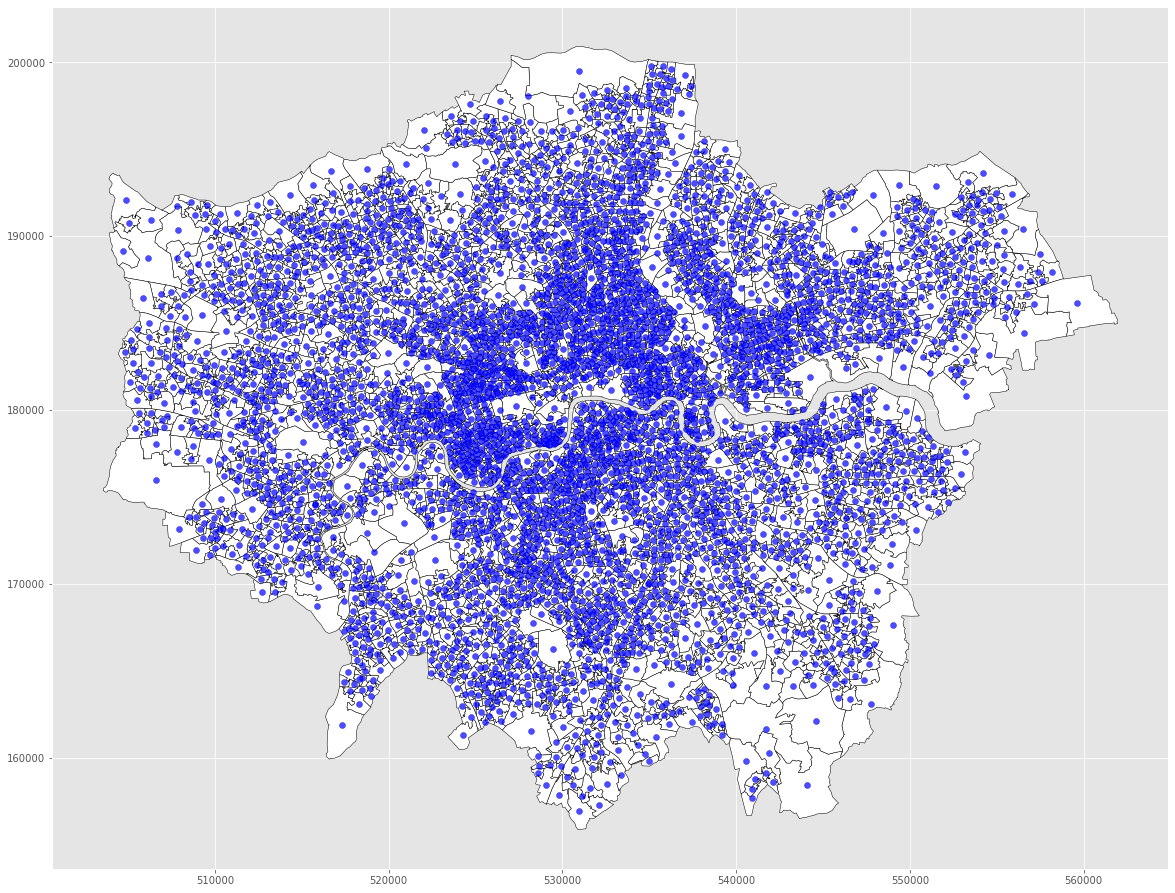

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
geo_lsoa.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
geo_lsoa.centroid.plot(ax=ax, c='blue',alpha = 0.7)

In [12]:
geo_lsoa["latitude"] = geo_lsoa.centroid.map(lambda p: p.x)
geo_lsoa["longitude"] = geo_lsoa.centroid.map(lambda p: p.y)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
print(geo_lsoa.shape)
geo_lsoa.head()

(4835, 7)


LSOA11CD                   LSOA11NM  USUALRES  \
0  E01000001        City of London 001A      1465   
1  E01000002        City of London 001B      1436   
2  E01000003        City of London 001C      1346   
3  E01000005        City of London 001E       985   
4  E01000006  Barking and Dagenham 016A      1703   

                                    POPDEN  \
0                                 112.9000   
1                                  62.9000   
2                                 227.7000   
3                                  52.0000   
4                                 116.2000   

                                            geometry  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...   
1  POLYGON ((532746.813 181786.891, 532671.688 18...   
2  POLYGON ((532135.145 182198.119, 532158.250 18...   
3  POLYGON ((533807.946 180767.770, 533649.063 18...   
4  POLYGON ((545122.049 184314.931, 545271.917 18...   

                                  latitude  \
0                             532,150.8794   
1                             532,443.3541   
2                             532,207.0623   
3                             533,618.5908   
4                             544,934.3677   

                                 longitude  
0                             181,615.0385  
1                             181,645.8619  
2                             182,030.0868  
3                             181,157.1185  
4                             184,297.5509

### Data cleaning

#### Clean the crime data.

There is a historical crime data for each LSOA.

In [14]:
# check all the columns to learn about all the columns.
print(list(crimeRaw.columns))

['LSOA Code', 'LSOA Name', 'Borough', 'Major Category', 'Minor Category', '201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '201901', '201902', '201004', '201005', '201006', '201007', '201008', '201009', '201010', '201011', '201012', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201201', '201202', '201203', '201204', '201205', '201206', '201207', '201208', '201209', '201210', '201211', '201212', '201301', '201302', '201303', '201304', '201305', '201306', '201307', '201308', '201309', '201310', '201311', '201312', '201401', '201402', '201403', '201404', '201405', '201406', '201407', '201408', '201409', '201410', '201411', '201412', '201501', '201502', '201503', '201504', '201505', '201506', '201507', '201508', '201509', '201510', '201511', '201512', '201601', '201602', '201603', '201604', '201605', '201606', '201607', '201608', '201609', '20161

Above shows the crime statistics were documented every month in a year from April 2010  to March 2021. Rather than choose one certain year, this analysis use the average crime rate per year as the dependent variable, aiming at showing a more comprehensive perspective about crime incidents in London over the last decade.

In [15]:
# sum up all the crime incidents
# and then calculate the average of crime per year, divide by a total year of 11 years.
crimeRaw['average_crime'] = crimeRaw.drop(['LSOA Code', 'LSOA Name', 'Borough', 'Major Category', 'Minor Category'],axis=1).sum(axis=1)/11

In [16]:
# save this to a new dataframe
crime = crimeRaw.copy()

In [17]:
# only keep the usable columns
crime = crime[['LSOA Code', 'LSOA Name', 'Borough', 'average_crime']]

In [18]:
# clean names of the columns
crime = crime.rename(columns={'LSOA Code': 'lsoa_code', 
                              'LSOA Name': 'lsoa_name'})

In [19]:
crime.shape

(147551, 4)

In [20]:
crime.head()

lsoa_code                  lsoa_name               Borough  \
0  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
2  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
3  E01000006  Barking and Dagenham 016A  Barking and Dagenham   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham   

                             average_crime  
0                                   0.7273  
1                                   7.0000  
2                                   0.6364  
3                                  11.8182  
4                                   0.4545

In [21]:
# sum up all categories of crime in each LSOA
crimeSum = crime.groupby(by=["lsoa_code"]).sum()

In [22]:
# set the lsoa code column as a normal column for later use
crimeSum["lsoa_cd"] = crimeSum.index

In [23]:
print(crimeSum.shape)
print(crimeSum.dtypes)
crimeSum.head()

(4829, 2)
average_crime    float64
lsoa_cd           object
dtype: object


average_crime    lsoa_cd
lsoa_code                                                    
E01000006                                  96.3636  E01000006
E01000007                                 390.9091  E01000007
E01000008                                 180.2727  E01000008
E01000009                                 250.0000  E01000009
E01000010                               1,141.3636  E01000010

##### Check crime distribution.

Now we have average crime data per year from 2010 to 2021. Then we check the data distribution, and make a map to spatially visualise it.

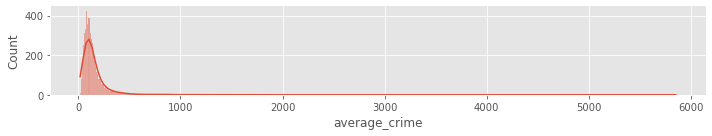

In [24]:
sns.displot(data=crimeSum, x="average_crime", kde=True,height=2,aspect=5)

<AxesSubplot:>

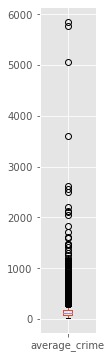

In [25]:
plt.figure(figsize=(1, 6))
crimeSum.boxplot("average_crime")

As shown above, the average crime data is extremely left-skewed. It is very likely a power law distribution. The vast amount of crime are less than about 3000. Although considering the likelihood of outliers, this distribution is common in real world: Maybe some of the most dangerous LSOAs have extremely high crime number. Thus, to make sure there isn't any outlier, we will normalise it by the population of each LSOA and then check the distribution again.

In [26]:
geo_crime = pd.merge(geo_lsoa, crimeSum, left_on='LSOA11CD', right_on='lsoa_cd', how='left')
print(geo_crime.shape)

geo_crime = geo_crime[['LSOA11CD', 'LSOA11NM','average_crime', 'USUALRES', 'POPDEN', 'latitude','longitude','geometry']]
geo_crime.head()

(4835, 9)


LSOA11CD                   LSOA11NM  \
0  E01000001        City of London 001A   
1  E01000002        City of London 001B   
2  E01000003        City of London 001C   
3  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A   

                             average_crime  USUALRES  \
0                                      NaN      1465   
1                                      NaN      1436   
2                                      NaN      1346   
3                                      NaN       985   
4                                  96.3636      1703   

                                    POPDEN  \
0                                 112.9000   
1                                  62.9000   
2                                 227.7000   
3                                  52.0000   
4                                 116.2000   

                                  latitude  \
0                             532,150.8794   
1                             532,443.3541   
2                             532,207.0623   
3                             533,618.5908   
4                             544,934.3677   

                                 longitude  \
0                             181,615.0385   
1                             181,645.8619   
2                             182,030.0868   
3                             181,157.1185   
4                             184,297.5509   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

##### check na data and try to fix it.

In [27]:
geo_crime[geo_crime['average_crime'].isna()]

LSOA11CD             LSOA11NM  average_crime  USUALRES  \
0     E01000001  City of London 001A            NaN      1465   
1     E01000002  City of London 001B            NaN      1436   
2     E01000003  City of London 001C            NaN      1346   
3     E01000005  City of London 001E            NaN       985   
4674  E01032739  City of London 001F            NaN      1044   
4675  E01032740  City of London 001G            NaN      1099   

                                       POPDEN  \
0                                    112.9000   
1                                     62.9000   
2                                    227.7000   
3                                     52.0000   
4674                                   6.3000   
4675                                  17.2000   

                                     latitude  \
0                                532,150.8794   
1                                532,443.3541   
2                                532,207.0623   
3                                533,618.5908   
4674                             532,769.0076   
4675                             531,508.9698   

                                    longitude  \
0                                181,615.0385   
1                                181,645.8619   
2                                182,030.0868   
3                                181,157.1185   
4674                             181,158.3505   
4675                             181,317.1162   

                                               geometry  
0     POLYGON ((532105.092 182011.230, 532162.491 18...  
1     POLYGON ((532746.813 181786.891, 532671.688 18...  
2     POLYGON ((532135.145 182198.119, 532158.250 18...  
3     POLYGON ((533807.946 180767.770, 533649.063 18...  
4674  MULTIPOLYGON (((531667.624 180534.992, 531647....  
4675  POLYGON ((532022.374 181893.469, 532021.188 18...

Notice there are some NA values: Six LSOAs of the City of London have no value: E01000001, E01000002, E01000003, E01000005, E01032739, E01032740. We will add it in the next part.

##### Add City of London Values. 

Due to a difference of police service, the original file doesn't include data from the City of London. We have to add another set of data files to fix this problem.

In [28]:
## prepare a list for a loop of reading separate files.
name_list = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
files = ["01","02","03","04","05","05","07","08","09","10","11","12"]
df = name_list.copy()

## prepare a dictionary for a new dataframe of city of London crime number.
missing_lsoa = ["E01000001","E01000002","E01000003","E01000005","E01032739","E01032740"]
city_of_London = {'lsoa_cd':missing_lsoa}

for i in range(12):
    ## read all the files.
    files[i] = pd.read_csv(f"data/cityofLondon/2022-{files[i]}/2022-{files[i]}-city-of-london-street.csv")
    ## build a new dataframe for every month total data. And then add all the month data up.
    df[i] = files[i].groupby(['LSOA code'])['LSOA code'].count()
    city_of_London[name_list[i]] = df[i][missing_lsoa]

df_CoL = pd.DataFrame(data=city_of_London)
df_CoL['city_of_London_year'] = df_CoL.drop("lsoa_cd",axis = 1).sum(axis=1)
df_CoL.head()

lsoa_cd  jan  feb  mar  apr  may  jun  jul  aug  sep  oct  nov  \
LSOA code                                                                     
E01000001  E01000001   14   18   27   18   17   17   13   15   14   19   17   
E01000002  E01000002   16   21   18   18   19   19   33   33   27   30   34   
E01000003  E01000003    5    9    8    4   11   11   18   15    7    7   11   
E01000005  E01000005   56   36   39   36   51   51   61   47   58   40   49   
E01032739  E01032739  371  376  461  435  450  450  444  491  414  510  476   

           dec  city_of_London_year  
LSOA code                            
E01000001   17                  206  
E01000002   24                  292  
E01000003    8                  114  
E01000005   53                  577  
E01032739  492                 5370

In [29]:
new_value = list(df_CoL["city_of_London_year"])

for i in range(6):
    geo_crime.loc[geo_crime.index[geo_crime['LSOA11CD'] == missing_lsoa[i]], 'average_crime'] = new_value[i]

In [30]:
geo_crime['average_crime'].isna().sum()

0

Now, there is no na values in the average crime number column, which means we can calculate the crime rate.

In [31]:
geo_crime["crime_rate"] = geo_crime["average_crime"]/(geo_crime["USUALRES"]/1000)

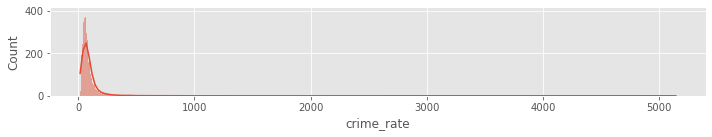

In [32]:
sns.displot(data=geo_crime, x="crime_rate", kde=True,height=2,aspect=5)

In [33]:
geo_crime.crime_rate.mean()

92.52911085443358

#### Check the LSOAs with high crime rates.

There are some LSOAs with extremely high crime rate. To make sure this is not caused by some error in the raw data, we should go back there and check the LSOA with the top high crime rates.

In [34]:
geo_crime.sort_values(by='average_crime', ascending=False).head(10)

LSOA11CD                   LSOA11NM  \
4613  E01004734           Westminster 018A   
4782  E01033595           Westminster 013E   
4674  E01032739        City of London 001F   
4640  E01004763           Westminster 013B   
4615  E01004736           Westminster 018C   
2902  E01002968  Kingston upon Thames 009C   
2392  E01002444            Hillingdon 031A   
4770  E01033583                Newham 013G   
4614  E01004735           Westminster 018B   
4593  E01004714           Westminster 011B   

                                average_crime  USUALRES  \
4613                               5,853.0909      1972   
4782                               5,770.1818      1175   
4674                               5,370.0000      1044   
4640                               5,065.5455      2127   
4615                               3,606.1818      1744   
2902                               2,612.9091      2631   
2392                               2,551.0000      1833   
4770                               2,503.6364      3081   
4614                               2,199.0909      1829   
4593                               2,116.4545      2150   

                                       POPDEN  \
4613                                  60.7000   
4782                                  22.9000   
4674                                   6.3000   
4640                                  72.4000   
4615                                  14.7000   
2902                                  47.3000   
2392                                   1.2000   
4770                                  19.5000   
4614                                  38.2000   
4593                                  63.3000   

                                     latitude  \
4613                             530,106.7247   
4782                             529,081.2265   
4674                             532,769.0076   
4640                             529,548.6996   
4615                             529,492.2841   
2902                             518,076.5113   
2392                             506,593.4610   
4770                             538,197.5670   
4614                             530,680.4871   
4593                             528,265.5450   

                                    longitude  \
4613                             180,717.9441   
4782                             180,931.5144   
4674                             181,158.3505   
4640                             181,329.7417   
4615                             180,107.0331   
2902                             169,189.0621   
2392                             175,962.4265   
4770                             184,808.8021   
4614                             180,978.0744   
4593                             181,349.1841   

                                               geometry  \
4613  POLYGON ((529960.283 181025.974, 530024.699 18...   
4782  POLYGON ((529379.222 181304.191, 529317.101 18...   
4674  MULTIPOLYGON (((531667.624 180534.992, 531647....   
4640  POLYGON ((529205.121 181846.675, 529279.644 18...   
4615  POLYGON ((529725.174 180538.236, 529750.157 18...   
2902  POLYGON ((518274.367 169564.882, 518310.721 16...   
2392  POLYGON ((505800.640 178396.796, 505715.181 17...   
4770  POLYGON ((538104.375 185580.312, 538153.766 18...   
4614  POLYGON ((530914.188 181358.203, 530977.999 18...   
4593  POLYGON ((528120.267 181661.865, 528144.653 18...   

                                   crime_rate  
4613                               2,968.0988  
4782                               4,910.7930  
4674                               5,143.6782  
4640                               2,381.5446  
4615                               2,067.7648  
2902                                 993.1239  
2392                               1,391.7076  
4770                                 812.6051  
4614                               1,202.3460  
4593                                 984.3975

Ok, most of the LSOAs with really high average crime rate are from Westminster. Next, go back to the "crimeRaw" data to check those big numbers of crime incidents. Guess: any massive protests or certain political movement or natural hazards happened in certain time that lead to lots of crime?

In [35]:
crimeRaw.loc[crimeRaw.index[crimeRaw['LSOA Code'] == "E01004734"]].sort_values("average_crime",ascending = False).head()

LSOA Code         LSOA Name      Borough               Major Category  \
140496  E01004734  Westminster 018A  Westminster                        Theft   
140498  E01004734  Westminster 018A  Westminster                        Theft   
140469  E01004734  Westminster 018A  Westminster                Drug Offences   
140504  E01004734  Westminster 018A  Westminster  Violence Against the Person   
140505  E01004734  Westminster 018A  Westminster  Violence Against the Person   

                 Minor Category  201903  201904  201905  201906  201907  ...  \
140496              Other Theft     300     392     308     212     199  ...   
140498        Theft from Person     464     372     217     209     140  ...   
140469      Possession of Drugs      38      23      16      32      25  ...   
140504     Violence with Injury      48      38      57      40      34  ...   
140505  Violence without Injury      55      50      50      55      30  ...   

        202007  202008  202009  202010  202011  202012  202101  202102  \
140496      62     100      93      72      41      41       6      10   
140498      48      68      65      83      33      65      12      10   
140469      36      46      28      37      19      32      10      19   
140504      22      26      22      24      11      21       5       2   
140505      30      32      46      36      30      12       9      14   

        202103                            average_crime  
140496      17                               1,839.0000  
140498      26                               1,322.2727  
140469      22                                 490.6364  
140504      10                                 448.2727  
140505      26                                 427.5455  

[5 rows x 138 columns]

The table shows the top 5 minor categories of crime in the LSOA "Westminster 018A" with the highest average crime rate among all 4835 LSOAs in Greater London area. It is noticeable that the theft incidents contribute the most to the high crime rate here. The drug offences and violence against the person follows behind. Based on some initial reaserch on the internet, these kinds of crime are usual in some of the Westminster parts, which make Westminster remained one of the topped-crime-rate borough for many years (see figure below).

<div>
<img src="https://raw.githubusercontent.com/yuxinnie/DSSS/main/image/crime2.png" width="600"/>
</div>

https://crimerate.co.uk/london

https://www.london.gov.uk/programmes-strategies/mayors-office-policing-and-crime/data-and-statistics/crime-dashboard

Thus, without removing value as outlier, now we can move on to the independent variables.

#### The final crime rate mapping.

Text(0.5, 0.98, 'Average crime rate () in London LSOAs (2010 ~ 2021)')

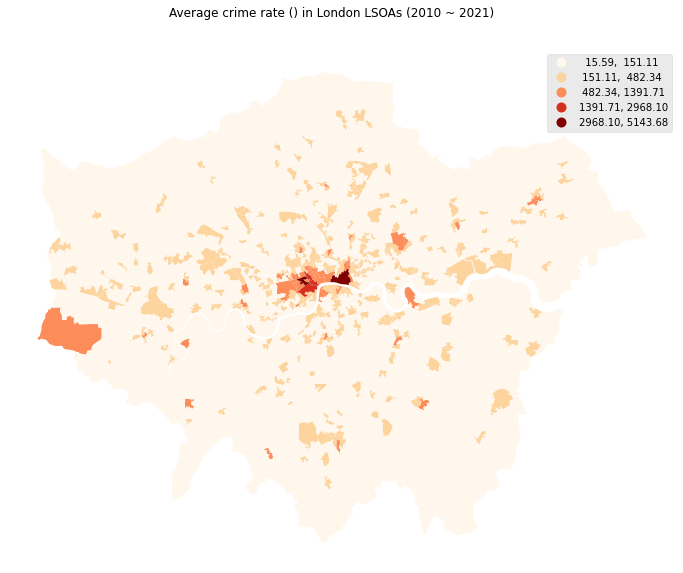

In [36]:
f = plt.figure(dpi = 72)
f.set_size_inches(12,10)

ax1 = f.add_subplot()
geo_crime.plot(column='crime_rate', legend=True, cmap='OrRd',  ax=ax1,scheme="Natural_Breaks")
ax1.set_axis_off()

f.subplots_adjust(top=1)
f.suptitle("Average crime rate () in London LSOAs (2010 ~ 2021)")

#### clean the environment features.

##### Clean greenary data.

In [37]:
canopyRaw.head()

lsoa_cd                    lsoa_nm  \
0  E01000001        City of London 001A   
1  E01000002        City of London 001B   
2  E01000003        City of London 001C   
3  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A   

                                 lsoa_kmsq  \
0                             129,865.0000   
1                             228,419.0000   
2                              59,054.0000   
3                             189,577.0000   
4                             146,537.0000   

                               canopy_kmsq  \
0                               7,498.8010   
1                               4,041.8030   
2                               5,220.9310   
3                               4,514.3000   
4                              21,777.6320   

                                canopy_per      la_cd                 la_nm  
0                                   5.7740  E09000001        City of London  
1                                   1.7690  E09000001        City of London  
2                                   8.8410  E09000001        City of London  
3                                   2.3810  E09000001        City of London  
4                                  14.8620  E09000002  Barking and Dagenham

In [38]:
canopyRaw.columns

Index(['lsoa_cd', 'lsoa_nm', 'lsoa_kmsq', 'canopy_kmsq', 'canopy_per', 'la_cd',
       'la_nm'],
      dtype='object')

In [39]:
canopy = canopyRaw[['lsoa_cd',  'canopy_per']]

In [40]:
geo_all_x = pd.merge(geo_crime, canopy, left_on="LSOA11CD", right_on = "lsoa_cd",how="inner")

In [41]:
geo_all_x.head()

LSOA11CD                   LSOA11NM  \
0  E01000001        City of London 001A   
1  E01000002        City of London 001B   
2  E01000003        City of London 001C   
3  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A   

                             average_crime  USUALRES  \
0                                 206.0000      1465   
1                                 292.0000      1436   
2                                 114.0000      1346   
3                                 577.0000       985   
4                                  96.3636      1703   

                                    POPDEN  \
0                                 112.9000   
1                                  62.9000   
2                                 227.7000   
3                                  52.0000   
4                                 116.2000   

                                  latitude  \
0                             532,150.8794   
1                             532,443.3541   
2                             532,207.0623   
3                             533,618.5908   
4                             544,934.3677   

                                 longitude  \
0                             181,615.0385   
1                             181,645.8619   
2                             182,030.0868   
3                             181,157.1185   
4                             184,297.5509   

                                            geometry  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...   
1  POLYGON ((532746.813 181786.891, 532671.688 18...   
2  POLYGON ((532135.145 182198.119, 532158.250 18...   
3  POLYGON ((533807.946 180767.770, 533649.063 18...   
4  POLYGON ((545122.049 184314.931, 545271.917 18...   

                                crime_rate    lsoa_cd  \
0                                 140.6143  E01000001   
1                                 203.3426  E01000002   
2                                  84.6954  E01000003   
3                                 585.7868  E01000005   
4                                  56.5846  E01000006   

                                canopy_per  
0                                   5.7740  
1                                   1.7690  
2                                   8.8410  
3                                   2.3810  
4                                  14.8620

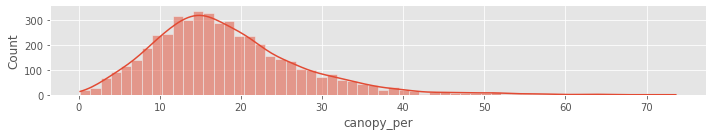

In [42]:
sns.displot(data=geo_all_x, x="canopy_per", kde=True,height=2,aspect=5)

##### population density data.

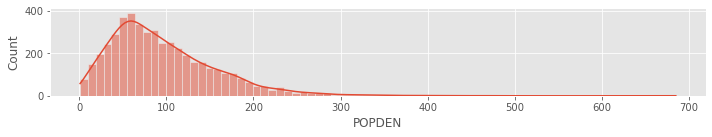

In [43]:
sns.displot(data=geo_all_x, x="POPDEN", kde=True,height=2,aspect=5)

##### council tax band data

In [44]:
print(councilTaxRaw.shape)
councilTaxRaw.head()

(5866, 13)


Geography  Area Code          Area Name        A        B        C        D  \
0    ENGWAL  K04000001  ENGLAND AND WALES  6006370  4927690  5439300  3852510   
1      NATL  E92000001            ENGLAND  5796220  4628160  5131260  3624710   
2      NATL  W92000004              WALES   208090   297430   305870   226210   
3      REGL  E12000001         NORTH EAST   658240   184580   176630    97010   
4      REGL  E12000002         NORTH WEST  1332020   641580   560170   323720   

         E        F       G       H                                        I  \
0  2417450  1292820  877420  149660                               5,450.0000   
1  2230040  1179160  825360  137070                                      NaN   
2   186330   113100   51680   12500                               5,430.0000   
3    49110    21370   12340    1400                                      NaN   
4   187040    91260   60280    6650                                      NaN   

   All Properties  
0        24968660  
1        23551980  
2         1406640  
3         1200670  
4         3202710

In [45]:
councilTaxRaw.sort_values("All Properties").head()

Geography  Area Code           Area Name   A    B    C    D    E   F  G  \
416       LSOA  E01000373         Bexley 008A  70   40  100   10    0   0  0   
4736      LSOA  E01032772  Tower Hamlets 032C   0  130   80   40   20  20  0   
4825      LSOA  E01033590      Redbridge 019H   0   30  240   90   20   0  -   
2168      LSOA  E01002170         Harrow 033A   0    0   20  260  110  20  0   
2173      LSOA  E01002175         Harrow 033F   0    -   60    -  250  90  -   

      H   I  All Properties  
416   0 NaN             220  
4736  0 NaN             290  
4825  0 NaN             370  
2168  0 NaN             410  
2173  0 NaN             410

In [46]:
councilTax = councilTaxRaw.copy()
councilTax.dtypes

Geography          object
Area Code          object
Area Name          object
A                  object
B                  object
C                  object
D                  object
E                  object
F                  object
G                  object
H                  object
I                 float64
All Properties      int64
dtype: object

In [47]:
councilTaxRaw.isna().sum()

Geography            0
Area Code            0
Area Name            0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
H                    0
I                 5864
All Properties       0
dtype: int64

In [48]:
councilTax = councilTaxRaw[['Area Code', 'A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'All Properties']]

In [49]:
councilTax = councilTax.astype(str)

In [50]:
councilTax = councilTax.applymap(lambda x: re.sub(r'^-$', "0", x))

In [51]:
band_list = ['E', 'F','G', 'H']

councilTax['All Properties'] = councilTax['All Properties'].astype(float)

for i in band_list:
    councilTax[i] = councilTax[i].astype(float)
    # councilTax[i] = councilTax[i]/councilTax['All Properties']
councilTax["low_bands"] = ((councilTax["E"]+councilTax["F"]+councilTax["G"]+councilTax["H"]+10)/councilTax['All Properties'])*100

In [52]:
councilTax.columns

Index(['Area Code', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'All Properties', 'low_bands'],
      dtype='object')

In [53]:
councilTax = councilTax[['Area Code', 'low_bands']]

In [54]:
councilTax.sort_values("low_bands").head()

Area Code                                low_bands
4889  E02000008                                   0.2123
4888  E02000007                                   0.2786
4895  E02000014                                   0.2786
5189  E02000315                                   0.2786
5607  E02000749                                   0.2915

In [55]:
councilTax.low_bands.isna().sum()

0

In [56]:
geo_all_x = pd.merge(geo_all_x, councilTax, left_on="LSOA11CD", right_on = "Area Code",how="inner")

In [57]:
geo_all_x.shape

(4835, 13)

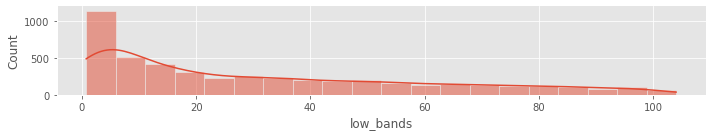

In [58]:
sns.displot(data=geo_all_x, x="low_bands", kde=True,height=2,aspect=5)

##### building age data

In [60]:
buildAgeRaw.head()

Unnamed: 0 Geography2 Area Code3          Area Pre 1900 1900 to 1918  \
0         NaN       REGN  E12000007        LONDON   779990       311380   
1         NaN       LAU1  E13000001  Inner London   545650       101810   
2         NaN       LAU2  E09000007        Camden    50240         3940   
3         NaN       MSOA  E02000166    Camden 001     1190          130   
4         NaN       LSOA  E01000907   Camden 001A      190            -   

  1919 to 1929 1930 to 1939 1945 to 1954 1955 to 1964 1965 to 1972  \
0       236830       610700       193650       244360       222440   
1        48640        96470        70400       101460        98850   
2         2880         6910         3750         7620         7670   
3         1150          190           40           80           70   
4            -           20            -            -           20   

  1973 to 1982 1983 to 1992 1993 to 1999 2000 to 2009 2010 to 2012 Unknown1  \
0       215410       158490       123840       233030        91180    34460   
1        97150        60760        57030       121250        48240    26130   
2         7480         3050         3320         5540         2070      960   
3          660           70           10           50            -      120   
4          370           20            -            -            -        -   

                                     Total  
0                           3,455,750.0000  
1                           1,473,830.0000  
2                             105,430.0000  
3                               3,740.0000  
4                                 620.0000

In [61]:
buildAgeRaw.columns

Index(['Unnamed: 0', 'Geography2', 'Area Code3', 'Area', 'Pre 1900',
       '1900 to 1918', '1919 to 1929', '1930 to 1939', '1945 to 1954',
       '1955 to 1964', '1965 to 1972', '1973 to 1982', '1983 to 1992',
       '1993 to 1999', '2000 to 2009', '2010 to 2012', 'Unknown1', 'Total'],
      dtype='object')

In [62]:
buildAgeRaw.isna().sum()

Unnamed: 0      5866
Geography2        12
Area Code3        12
Area               3
Pre 1900          12
1900 to 1918      12
1919 to 1929      12
1930 to 1939      12
1945 to 1954      12
1955 to 1964      12
1965 to 1972      12
1973 to 1982      12
1983 to 1992      12
1993 to 1999      12
2000 to 2009      12
2010 to 2012      12
Unknown1          12
Total             12
dtype: int64

In [63]:
building_age = buildAgeRaw[['Area Code3', '2000 to 2009', '2010 to 2012', 'Total']]
print(building_age.shape)

(5866, 4)


In [64]:
building_age = building_age.astype(str).applymap(lambda x: re.sub(r'^-$', "0", x))

In [65]:
trans_list = ['Area Code3',  '2000 to 2009', '2010 to 2012', 'Total']

for i in trans_list:
    if i == 'Area Code3':
        continue
    else:
        building_age[i] = building_age[i].astype(float)

building_age["new_buildings"] = ((building_age['2000 to 2009'] + building_age['2010 to 2012']+50)/building_age['Total'])*100

In [66]:
building_age.sort_values("new_buildings",ascending = False).head()

Area Code3                             2000 to 2009  \
1537  E01033574                                 550.0000   
4047  E01033743                                 620.0000   
4044  E01033739                                 620.0000   
4207  E01033732                                 490.0000   
4208  E01033733                                 600.0000   

                                 2010 to 2012  \
1537                                   0.0000   
4047                                   0.0000   
4044                                   0.0000   
4207                                   0.0000   
4208                                 140.0000   

                                        Total  \
1537                                 550.0000   
4047                                 620.0000   
4044                                 620.0000   
4207                                 500.0000   
4208                                 740.0000   

                                new_buildings  
1537                                 109.0909  
4047                                 108.0645  
4044                                 108.0645  
4207                                 108.0000  
4208                                 106.7568

In [67]:
building_age.isna().sum()

Area Code3        0
2000 to 2009     12
2010 to 2012     12
Total            12
new_buildings    12
dtype: int64

In [68]:
building_age = building_age[['Area Code3', 'new_buildings']]

In [69]:
geo_all_x = pd.merge(geo_all_x, building_age, left_on="LSOA11CD", right_on = "Area Code3",how="inner")

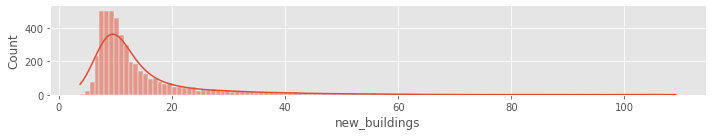

In [70]:
sns.displot(data=geo_all_x, x="new_buildings", kde=True,height=2,aspect=5)

##### POI data

Down all the POI data from: https://digimap.edina.ac.uk/os (this study uses points of interests in year 2018)

`Due to the time-consuming process of pre-process the POI data, I did it in advance in QGIS. Here are the steps I did:`

1. Divide all the 7 categories point data into 7 shapefiles.
1. Count the number of points for each type of points in each LSOA.
1. Join the counts attribute into one file.
1. Calculate the area of each LSOA.
1. points density = Number of points * 10000 /area of LSOA (multiply 10000 just to scale the number to a proper range), screen shot below.
1. export a geojson file, and use it here.

<div>
<img src="https://raw.githubusercontent.com/yuxinnie/DSSS/main/image/QGIS1.png" width="400"/>
</div>

In [71]:
londonPOIraw = gpd.read_file('https://raw.githubusercontent.com/yuxinnie/DSSS/main/data/London_POI_density2.geojson')

In [72]:
londonPOIraw.head()

LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...                            transport_NUM  \
0  ...                                  11.0000   
1  ...                                  12.0000   
2  ...                                   1.0000   
3  ...                                  24.0000   
4  ...                                   4.0000   

                                shape_area  \
0                             133,320.7690   
1                             226,191.2730   
2                              57,302.9670   
3                             190,738.7610   
4                             144,195.8470   

                               eat_density  \
0                                   2.1750   
1                                   1.8130   
2                                   1.0470   
3                                   3.7750   
4                                   0.0690   

                        attraction_density  \
0                                   2.0250   
1                                   1.4590   
2                                   0.8730   
3                                   0.2100   
4                                   0.0690   

                        edu_health_density  \
0                                   0.9000   
1                                   0.7520   
2                                   0.6980   
3                                   0.6820   
4                                   0.2080   

                      public_infra_density  \
0                                   1.6500   
1                                   1.4590   
2                                   1.3960   
3                                   2.3590   
4                                   0.4850   

                            retail_density  \
0                                   0.5250   
1                                   0.3980   
2                                   1.2220   
3                                   1.6250   
4                                   0.0690   

                  sports_entertain_density  \
0                                   0.8250   
1                                   0.4860   
2                                   0.5240   
3                                   0.7860   
4                                   0.0690   

                         transport_density  geometry  
0                                   0.9000      None  
1                                   0.5750      None  
2                                   0.3490      None  
3                                   1.3110      None  
4                                   0.3470      None  

[5 rows x 30 columns]

In [73]:
londonPOI = londonPOIraw[['LSOA11CD',
       'eat_density', 
       'attraction_density',
        'edu_health_density',
       'public_infra_density', 
       'retail_density', 
       'sports_entertain_density', 
        'transport_density']]

<AxesSubplot:>

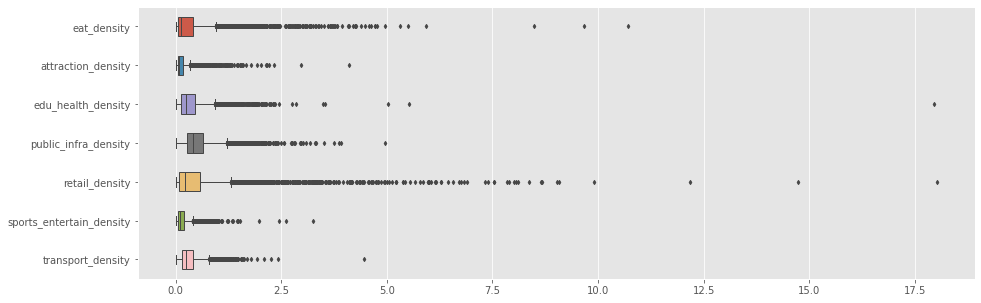

In [74]:
plt.figure(figsize=(15,5))
sns.boxplot(data=londonPOI,width=0.5,orient = 'h',linewidth=1,fliersize = 3)

In [75]:
geo_all_x = pd.merge(geo_all_x, londonPOI, left_on="LSOA11CD", right_on = "LSOA11CD",how="inner")

### Data presentation

#### Variable explaination

`The 14 columns of this dataframe are:`

**Dependent variable:**
1. *crime_rate*: the average crime rate per year per 1000 people from 2010 to 2021

**Independent variables (features):**
1. *POPDEN*: population density in LSOA
1. *canopy_per*: the greenary coverage per kmsq in each LSOA
1. *low_bands*: the percentage of council tax band E,F,G,H in each LSOA
1. *new_buildings*: the percentage of buildings built after year 2000 in each LSOA

1. *attraction_density*: the density of attraction points (tourism,etc) in each LSOA
1. *eat_density*: the density of eating points (restaurant,etc) in each LSOA
1. *edu_health_density*: the density of education and health points in each LSOA
1. *public_infra_density*: the density of public infrastructure points in each LSOA
1. *retail_density*: the density of retailing points in each LSOA
1. *sports_entertain_density*: the density of sports and entertainment facility points (stadium, casino, etc) in each LSOA
1. *transport_density*: the density of transport facility (tube stations,etc) points in each LSOA

1. *latitude*: the latitude of the centroid of each LSOA
1. *longitude*: the longitude of the centroid of each LSOA


#### Spatial distribution of data

Make maps to check the spatial distribution of independent variables.

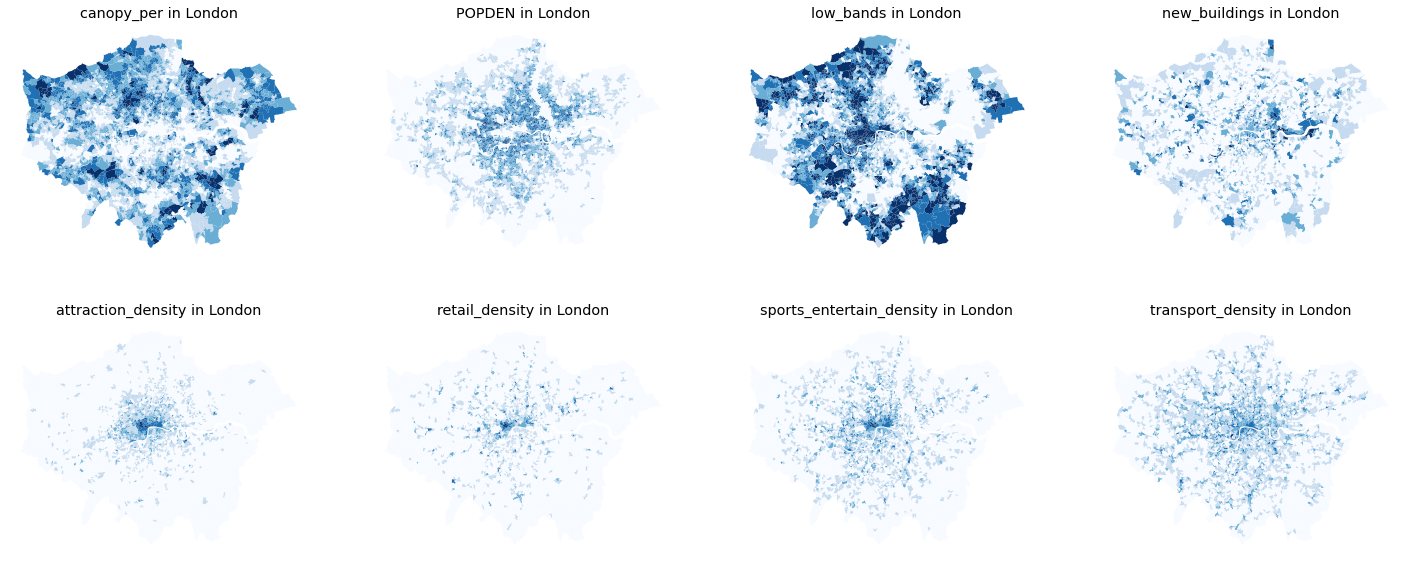

In [142]:
list_figure = ['canopy_per',
                'POPDEN',
                'low_bands',
                'new_buildings',
                'attraction_density', 
                'retail_density',
                'sports_entertain_density',
                'transport_density']

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(25,10))

for counter in range(8):
    i = counter // 4
    j = counter % 4
    ax = axes[i,j]
    
    ax.title.set_text(f"{list_figure[counter]} in London")
    ax.axis("off")
    geo_all_x.plot(column=list_figure[counter], legend=False, cmap="Blues", ax = ax,scheme="Natural_Breaks")

## Data analysis

To measure the correlation between the independent variables and the dependent variables, this coursework will apply a statistical analysis fisrt: Build multiple linear regression by OLS (ordinary least squares).

### Prepare data for OLS model

In [77]:
geo_all_x.columns

Index(['LSOA11CD', 'LSOA11NM', 'average_crime', 'USUALRES', 'POPDEN',
       'latitude', 'longitude', 'geometry', 'crime_rate', 'lsoa_cd',
       'canopy_per', 'Area Code', 'low_bands', 'Area Code3', 'new_buildings',
       'eat_density', 'attraction_density', 'edu_health_density',
       'public_infra_density', 'retail_density', 'sports_entertain_density',
       'transport_density'],
      dtype='object')

In [78]:
predict_table = geo_all_x.drop(['LSOA11CD', 'LSOA11NM', 'USUALRES', 'lsoa_cd','Area Code', 'Area Code3','average_crime'],axis = 1)

#### Scale data

Standardisation of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data 
(*https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html*).

Not only in machine learning estimators as mentioned above, scaling data is also an important step for statistical analysis. As shown in the data pre-processing part, the distributionof most of the variables are highly left-skewed. In this case, logarithm is a good way to scale data for a better fitted linear regression model. 

In the following, this study will (1) use logarithm to rescaling the distribution of skewed values,(2) use StandardScaler to standardise features by removing the mean and scaling to unit variance.

In [79]:
predict_table.describe()

POPDEN  \
count                               4,835.0000   
mean                                   95.9375   
std                                    61.2236   
min                                     1.2000   
25%                                    51.9500   
50%                                    83.3000   
75%                                   128.4000   
max                                   684.7000   

                                      latitude  \
count                               4,835.0000   
mean                              530,724.6175   
std                                10,756.6676   
min                               504,718.9650   
25%                               523,887.5589   
50%                               530,991.0516   
75%                               537,855.3235   
max                               559,641.7152   

                                     longitude  \
count                               4,835.0000   
mean                              180,245.7733   
std                                 8,417.5259   
min                               156,925.2227   
25%                               174,316.1563   
50%                               180,963.0889   
75%                               186,556.5631   
max                               199,818.2489   

                                    crime_rate  \
count                               4,835.0000   
mean                                   92.5291   
std                                   147.2553   
min                                    15.5891   
25%                                    49.2293   
50%                                    67.4151   
75%                                    96.1423   
max                                 5,143.6782   

                                    canopy_per  \
count                               4,835.0000   
mean                                   18.1881   
std                                     9.2799   
min                                     0.1650   
25%                                    11.9780   
50%                                    16.7020   
75%                                    22.7075   
max                                    73.6080   

                                     low_bands  \
count                               4,835.0000   
mean                                   31.7928   
std                                    28.7012   
min                                     0.7576   
25%                                     6.4516   
50%                                    22.5352   
75%                                    51.5152   
max                                   104.0000   

                                 new_buildings  \
count                               4,835.0000   
mean                                   15.3161   
std                                    13.1176   
min                                     3.7313   
25%                                     8.6207   
50%                                    10.8696   
75%                                    15.8730   
max                                   109.0909   

                                   eat_density  \
count                               4,835.0000   
mean                                    0.3679   
std                                     0.6272   
min                                     0.0020   
25%                                     0.0540   
50%                                     0.1300   
75%                                     0.4135   
max                                    10.6970   

                            attraction_density  \
count                               4,835.0000   
mean                                    0.1536   
std                                     0.2031   
min                                     0.0050   
25%                                     0.0530   
50%                                     0.0880   
75%                                     0.1720   
max                             

- Use logarithm to scale it.

In [80]:
crime_log = predict_table.copy()
for column in list(crime_log.columns):
    if column in ["latitude","longitude","geometry"]:
        continue
    else:
        crime_log[column] = np.log(crime_log[column])
crime_log.describe()

POPDEN  \
count                               4,835.0000   
mean                                    4.3355   
std                                     0.7499   
min                                     0.1823   
25%                                     3.9503   
50%                                     4.4224   
75%                                     4.8552   
max                                     6.5290   

                                      latitude  \
count                               4,835.0000   
mean                              530,724.6175   
std                                10,756.6676   
min                               504,718.9650   
25%                               523,887.5589   
50%                               530,991.0516   
75%                               537,855.3235   
max                               559,641.7152   

                                     longitude  \
count                               4,835.0000   
mean                              180,245.7733   
std                                 8,417.5259   
min                               156,925.2227   
25%                               174,316.1563   
50%                               180,963.0889   
75%                               186,556.5631   
max                               199,818.2489   

                                    crime_rate  \
count                               4,835.0000   
mean                                    4.2760   
std                                     0.5999   
min                                     2.7466   
25%                                     3.8965   
50%                                     4.2109   
75%                                     4.5658   
max                                     8.5455   

                                    canopy_per  \
count                               4,835.0000   
mean                                    2.7610   
std                                     0.5707   
min                                    -1.8018   
25%                                     2.4831   
50%                                     2.8155   
75%                                     3.1227   
max                                     4.2988   

                                     low_bands  \
count                               4,835.0000   
mean                                    2.8436   
std                                     1.2915   
min                                    -0.2776   
25%                                     1.8643   
50%                                     3.1151   
75%                                     3.9419   
max                                     4.6444   

                                 new_buildings  \
count                               4,835.0000   
mean                                    2.5364   
std                                     0.5485   
min                                     1.3168   
25%                                     2.1542   
50%                                     2.3860   
75%                                     2.7646   
max                                     4.6922   

                                   eat_density  \
count                               4,835.0000   
mean                                   -1.9048   
std                                     1.3591   
min                                    -6.2146   
25%                                    -2.9188   
50%                                    -2.0402   
75%                                    -0.8831   
max                                     2.3700   

                            attraction_density  \
count                               4,835.0000   
mean                                   -2.3175   
std                                     0.8826   
min                                    -5.2983   
25%                                    -2.9375   
50%                                    -2.4304   
75%                                    -1.7603   
max                             

- Then use StandardScaler to StandardScaler the data.

In [81]:
crime_scaled = crime_log.drop("geometry",axis = 1)
nrmlzd = StandardScaler()
crime_scaled =nrmlzd.fit_transform(crime_scaled)

In [82]:
crime_scaled= pd.DataFrame(crime_scaled, 
                       index=crime_log.index,
                       columns=crime_log.drop("geometry",axis = 1).columns)
crime_scaled.describe()

POPDEN  \
count                               4,835.0000   
mean                                   -0.0000   
std                                     1.0001   
min                                    -5.5392   
25%                                    -0.5138   
50%                                     0.1159   
75%                                     0.6930   
max                                     2.9255   

                                      latitude  \
count                               4,835.0000   
mean                                    0.0000   
std                                     1.0001   
min                                    -2.4179   
25%                                    -0.6357   
50%                                     0.0248   
75%                                     0.6630   
max                                     2.6886   

                                     longitude  \
count                               4,835.0000   
mean                                    0.0000   
std                                     1.0001   
min                                    -2.7708   
25%                                    -0.7045   
50%                                     0.0852   
75%                                     0.7498   
max                                     2.3254   

                                    crime_rate  \
count                               4,835.0000   
mean                                   -0.0000   
std                                     1.0001   
min                                    -2.5500   
25%                                    -0.6328   
50%                                    -0.1087   
75%                                     0.4831   
max                                     7.1182   

                                    canopy_per  \
count                               4,835.0000   
mean                                    0.0000   
std                                     1.0001   
min                                    -7.9962   
25%                                    -0.4870   
50%                                     0.0956   
75%                                     0.6339   
max                                     2.6950   

                                     low_bands  \
count                               4,835.0000   
mean                                    0.0000   
std                                     1.0001   
min                                    -2.4170   
25%                                    -0.7583   
50%                                     0.2102   
75%                                     0.8505   
max                                     1.3945   

                                 new_buildings  \
count                               4,835.0000   
mean                                    0.0000   
std                                     1.0001   
min                                    -2.2238   
25%                                    -0.6969   
50%                                    -0.2742   
75%                                     0.4162   
max                                     3.9309   

                                   eat_density  \
count                               4,835.0000   
mean                                   -0.0000   
std                                     1.0001   
min                                    -3.1714   
25%                                    -0.7462   
50%                                    -0.0997   
75%                                     0.7518   
max                                     3.1456   

                            attraction_density  \
count                               4,835.0000   
mean                                    0.0000   
std                                     1.0001   
min                                    -3.3777   
25%                                    -0.7025   
50%                                    -0.1279   
75%                                     0.6315   
max                             

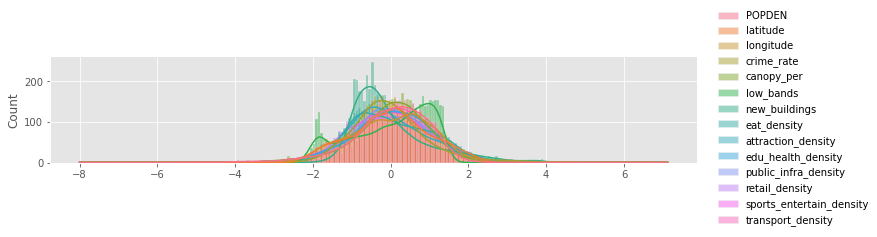

In [83]:
sns.displot(data=crime_scaled,  kde=True,height=2,aspect=5)

This is the satisfying distribution for model construction.

CPU times: user 12.9 s, sys: 333 ms, total: 13.3 s
Wall time: 12.8 s


<Figure size 40x40 with 0 Axes>

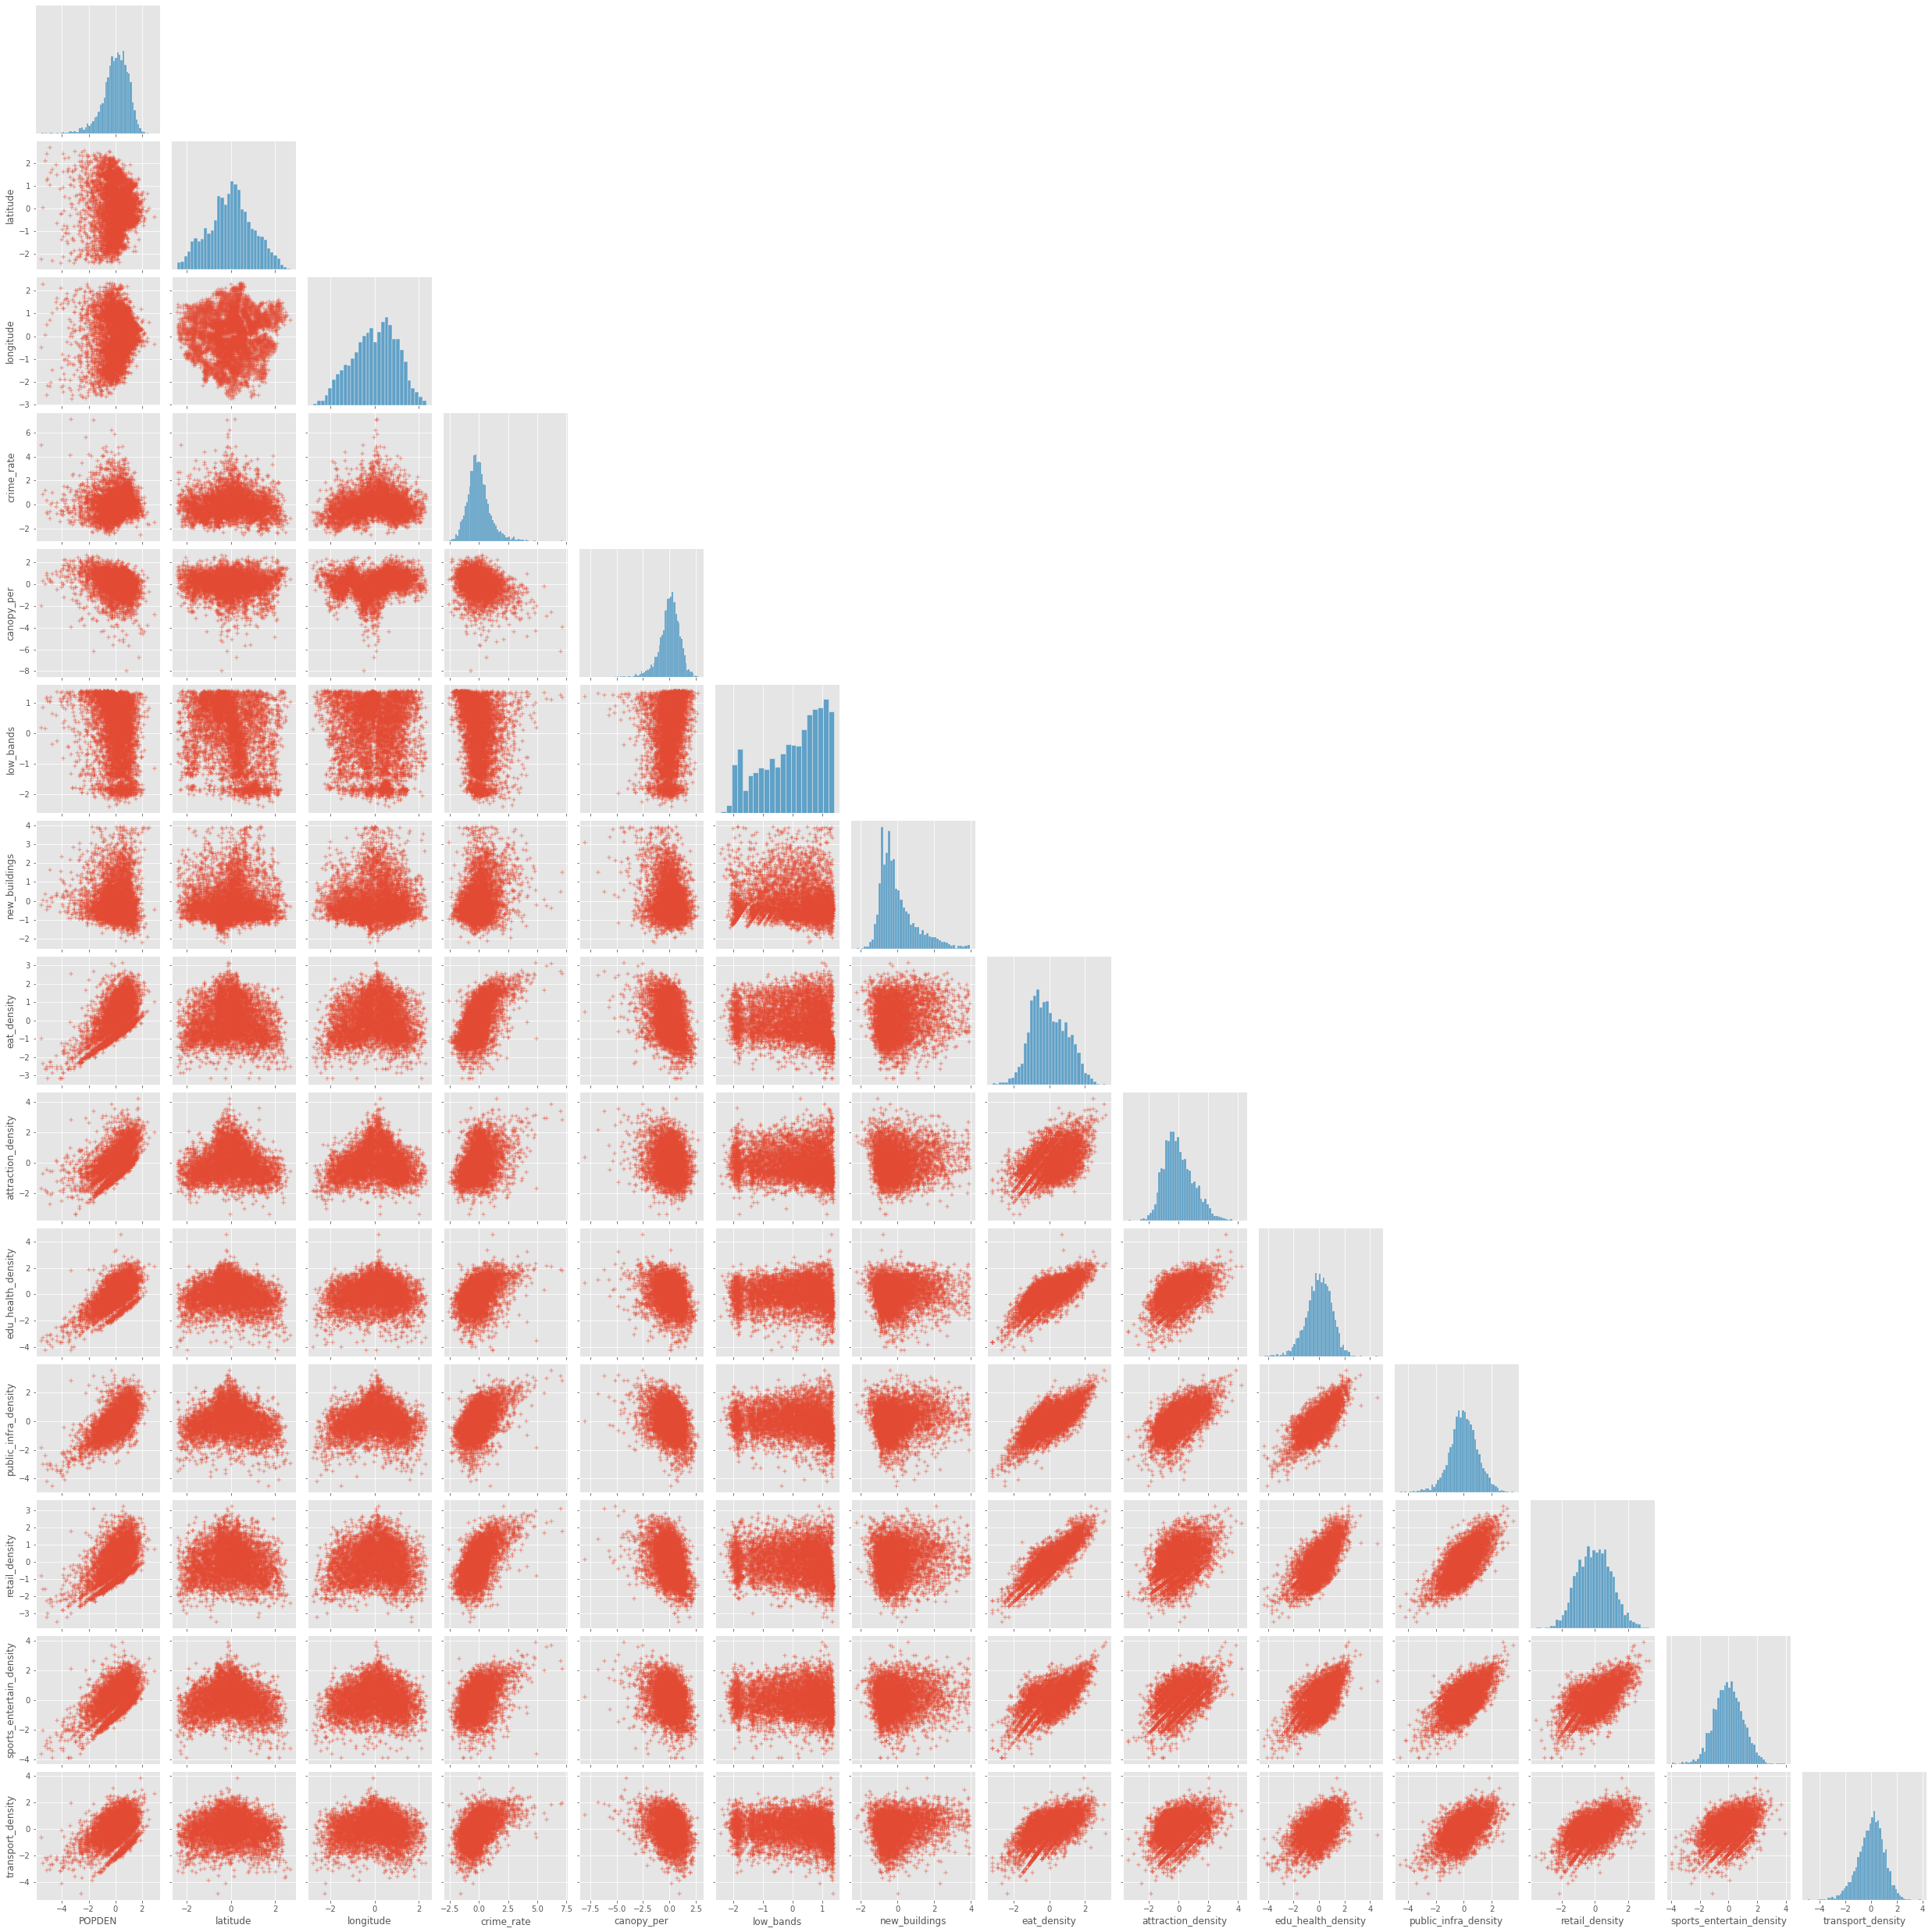

In [84]:
%%time
# Draw a pair scatter plot to show relationships between each column.
plt.figure(figsize=(5,5),dpi = 8)
sns.pairplot(crime_scaled,markers="+",corner=True)

#### Deal with multicollinearity 

`Multicollinearity emerges when two or more independent variables which are highly correlated are included in a model.`
One way of visually exporing multicollinearity is through a correlation matrix:

Text(0.5, 1.0, 'Correlation Matrix')

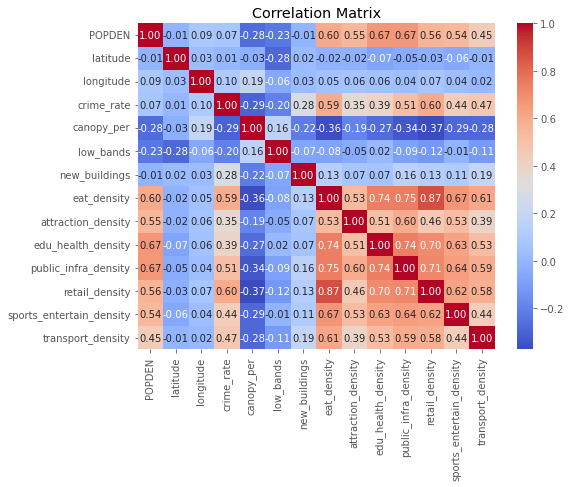

In [85]:
plt.figure(figsize=(8,6))
sns.heatmap(crime_scaled.corr(), # plot a correlation matrix 
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

It is easy to find from the above figure that some of the POI density variables are possible to have multicollinearity issue, especially the density of eat points and the density of retail points. This make sense as these two types of stores usually located together. 

Though a very high correlagtion coefficient between independent variables is a cause for concern, the formal way of dealing with muticollinearity is through the use of the `Variance Inflation Factor (VIF)`. VIF is the ratio of the variance in a model with multiple predictors by the variance of a model with a single predictor: 
$$\ VIF_j=\frac{1}{1-R_{j}^{2}}$$
This study choose 5 as the threshold.

In [86]:
#Using VIF to deal with multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    while True:
        df_with_const = add_constant(df)
        
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        
        vif_df = vif_df.drop('const')
        
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df

In [87]:
df_predictors_selected_VIF = drop_column_using_vif_(crime_scaled.drop('crime_rate', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: eat_density
The columns remaining after VIF selection are:
Index(['POPDEN', 'latitude', 'longitude', 'canopy_per', 'low_bands',
       'new_buildings', 'attraction_density', 'edu_health_density',
       'public_infra_density', 'retail_density', 'sports_entertain_density',
       'transport_density'],
      dtype='object')


VIF helps us drop the density of eating points variable. Put all the other remained variables into the OLS model.

### Build the OLS model and interpret the results

In [88]:
model = sm.OLS(endog=crime_scaled[['crime_rate']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     832.1
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:25:47   Log-Likelihood:                -4148.3
No. Observations:                4835   AIC:                             8323.
Df Residuals:                    4822   BIC:                             8407.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -9.058e-16      0.008   -1.1e-13      1.000      -0.016       0.016
POPDEN                      -0.7393      0.013    -57.329      0.000      -0.765      -0.714
latitude                    -0.0359      0.009     -4.172      0.000      -0.053      -0.019
longitude                    0.1037      0.009     12.101      0.000       0.087       0.121
canopy_per                  -0.0657      0.009     -6.939      0.000      -0.084      -0.047
low_bands                   -0.2626      0.009    -28.327      0.000      -0.281      -0.244
new_buildings                0.0788      0.009      9.038      0.000       0.062       0.096
attraction_density           0.1707      0.011     15.760      0.000       0.149       0.192
edu_health_density           0.0999      0.014      6.897      0.000       0.072       0.128
public_infra_density         0.3060      0.015     20.134      0.000       0.276       0.336
retail_density               0.3850      0.014     28.207      0.000       0.358       0.412
sports_entertain_density     0.1497      0.012     12.597      0.000       0.126       0.173
transport_density            0.1516      0.011     14.093      0.000       0.131       0.173
==============================================================================
Omnibus:                      109.822   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.237
Skew:                           0.259   Prob(JB):                     3.22e-34
Kurtosis:                       3.705   Cond. No.                         4.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`The summary of the OLS model is informative:`
- This regression model is significant as the p value is much less than 0.05 (Prob (F-statistic):0.00)
- All the independent variables can explain a total of 67.4% of the dependent variable crime rate. (R-squared:0.674) Also, the adjusted R2 is the same as the R2 value. (Adj. R-squared:0.674)
- In the following table, P>|t| column shows that all the variables are significant.
- POPDEN, latitude, longitude, canopy_per, low_bands are negatively correlate with crime rate, which means when these five variables improve, the crime rate will reduce. 
- new_buildings, attraction_density, edu_health_density, public_infra_density, retail_density, sports_entertain_density, transport_density have positive relationships with the crime rate. Rise in these variables could lead to different amount of increase of crime rate.
- Comparing all the 7 POI density data, density of retailing and public infrastructure rank the top 2. This illustrates that retailing points and public infrastructure points have a respectively strong positive effect on the crime rate. 


The 13 features highly-correlated with crime rate can be used to predict local crime rate. We noticed that some of them influences much less than the others (such as the latitude). Thus, this study will use unsupervised learning techniques to reduce the dimension. This is a really effective way to cut off the number of input features and save computation calculation costs, espacially for machine learning methods. The PCA analysis will be carried out in the next part.

### PCA

In [89]:
from sklearn.decomposition import PCA 

In [90]:
crime_scaled.columns

Index(['POPDEN', 'latitude', 'longitude', 'crime_rate', 'canopy_per',
       'low_bands', 'new_buildings', 'eat_density', 'attraction_density',
       'edu_health_density', 'public_infra_density', 'retail_density',
       'sports_entertain_density', 'transport_density'],
      dtype='object')

In [91]:
pcadf = crime_scaled.copy()
x = crime_scaled.drop(['crime_rate'],axis=1)

In [92]:
pcadf.columns

Index(['POPDEN', 'latitude', 'longitude', 'crime_rate', 'canopy_per',
       'low_bands', 'new_buildings', 'eat_density', 'attraction_density',
       'edu_health_density', 'public_infra_density', 'retail_density',
       'sports_entertain_density', 'transport_density'],
      dtype='object')

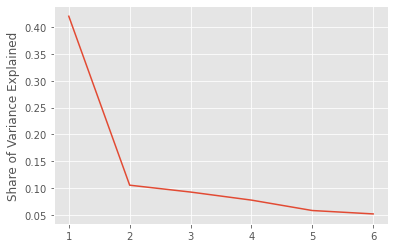

Total explained variance: 80.51%
Component  0 accounts for 42.05% of variance
Component  1 accounts for 10.52% of variance
Component  2 accounts for 9.24% of variance
Component  3 accounts for 7.74% of variance
Component  4 accounts for 5.79% of variance
Component  5 accounts for 5.16% of variance


In [93]:
pca = PCA(n_components=6, whiten=True) 
pca.fit(pcadf)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents,
              columns = ['principal component 1', 'principal component 2',
                          'principal component 3','principal component 4',
                          'principal component 5','principal component 6'])

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

pc_x = np.arange(1,len(explained_variance)+1)
plt.plot(pc_x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()
print(f"Total explained variance: {pca.explained_variance_ratio_.sum()*100:2.2f}%")
for i in range(0, 6):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

In [94]:
crime_scaled.columns

Index(['POPDEN', 'latitude', 'longitude', 'crime_rate', 'canopy_per',
       'low_bands', 'new_buildings', 'eat_density', 'attraction_density',
       'edu_health_density', 'public_infra_density', 'retail_density',
       'sports_entertain_density', 'transport_density'],
      dtype='object')

In [95]:
principalDf["crime_rate"] = crime_scaled["crime_rate"]
principalDf["latitude"] = crime_scaled["latitude"]
principalDf["longitude"] = crime_scaled["longitude"]

In [96]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]

loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = crime_scaled.drop(['crime_rate'],axis=1).columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

PC1  \
variable                                                            
POPDEN                                                    -0.3294   
latitude                                                   0.0148   
longitude                                                 -0.0259   
canopy_per                                                 0.1902   
low_bands                                                  0.0589   
new_buildings                                             -0.0763   
eat_density                                               -0.3845   
attraction_density                                        -0.2926   
edu_health_density                                        -0.3619   
public_infra_density                                      -0.3774   
retail_density                                            -0.3689   
sports_entertain_density                                  -0.3335   
transport_density                                         -0.3015   

                                                              PC2  \
variable                                                            
POPDEN                                                     0.0288   
latitude                                                   0.5964   
longitude                                                 -0.0250   
canopy_per                                                -0.2960   
low_bands                                                 -0.6549   
new_buildings                                              0.2770   
eat_density                                               -0.0266   
attraction_density                                        -0.0814   
edu_health_density                                        -0.1520   
public_infra_density                                      -0.0354   
retail_density                                             0.0050   
sports_entertain_density                                  -0.1121   
transport_density                                          0.0728   

                                                              PC3  \
variable                                                            
POPDEN                                                    -0.2042   
latitude                                                  -0.2470   
longitude                                                 -0.6628   
canopy_per                                                -0.4951   
low_bands                                                  0.2123   
new_buildings                                              0.3744   
eat_density                                                0.0119   
attraction_density                                        -0.1339   
edu_health_density                                        -0.0529   
public_infra_density                                      -0.0064   
retail_density                                             0.0114   
sports_entertain_density                                  -0.0057   
transport_density                                          0.0809   

                                                              PC4  \
variable                                                            
POPDEN                                                    -0.1966   
latitude                                                  -0.1555   
longitude                                                  0.5592   
canopy_per                                                 0.0852   
low_bands                                                  0.1435   
new_buildings                                              0.7590   
eat_density                                                0.0127   
attraction_density                                        -0.0508   
edu_health_density                                        -0.0476   
public_infra_density                                      -0.0003   
retail_density                                             0.0264   
sports_entertain_density                                 

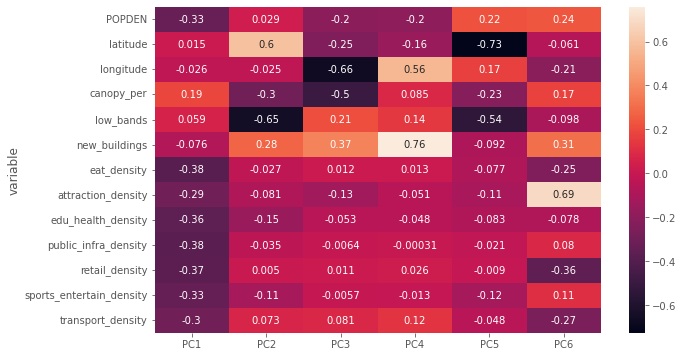

In [97]:
#Correlation matrix plot for loadings 
plt.rcParams['figure.figsize'] = (10,6)
ax = sns.heatmap(loadings_df, annot=True)
plt.show()

In [98]:
import sys
if 'bioinfokit' not in sys.modules:
    !pip3 install bioinfokit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


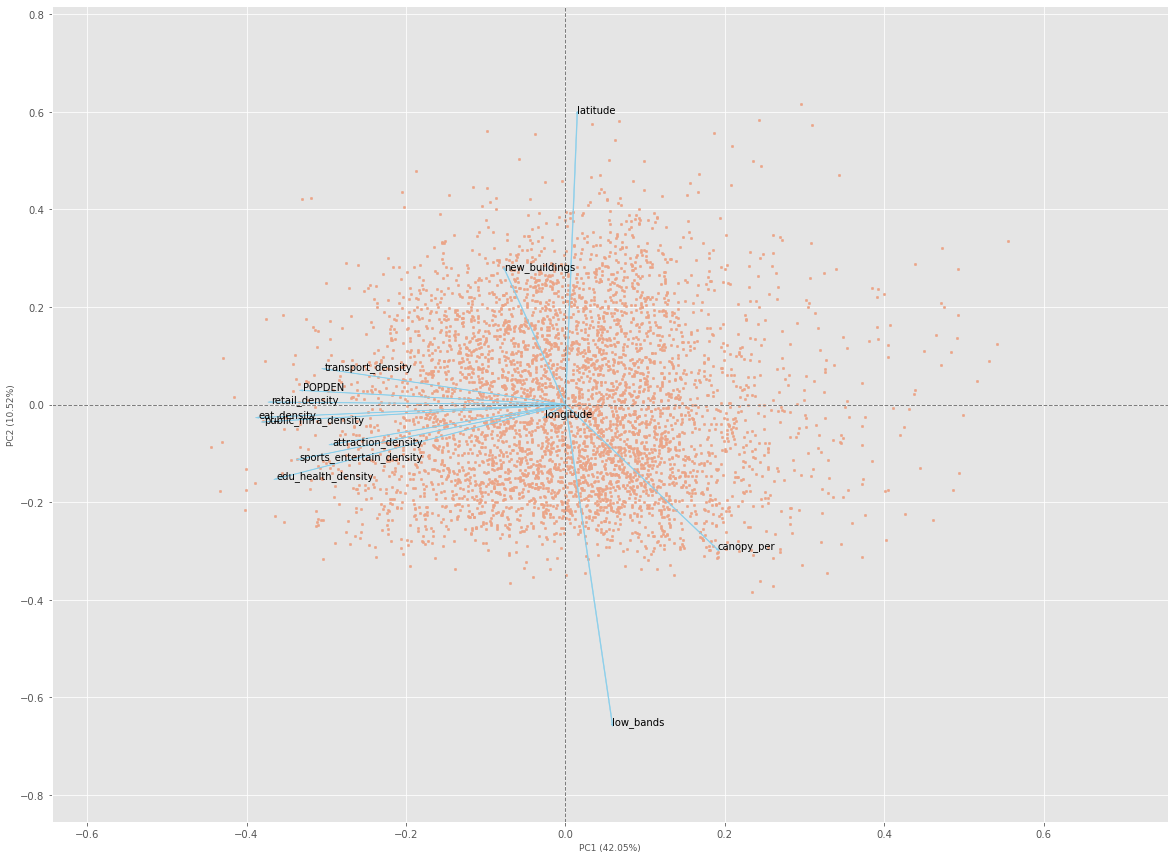

In [99]:
from bioinfokit.visuz import cluster
# get 2D biplot
cluster.biplot(cscore=principalComponents, 
               loadings=pca.components_, 
               labels=crime_scaled.drop(['crime_rate'],axis=1).columns.values,
               var1=round(pca.explained_variance_ratio_[0]*100, 2),
                var2=round(pca.explained_variance_ratio_[1]*100, 2), show=True, dim=(20,15))

The density of points features contribute a lot to the PC1, while the low_bands, latitude and the canopy per kmsq contribute more to the PC2.

In [100]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = crime_scaled.drop(['crime_rate'],axis=1).columns.values) # the list_var_X is used as the column names
df_PrincipleComp

POPDEN  \
0                                  -0.3294   
1                                   0.0288   
2                                  -0.2042   
3                                  -0.1966   
4                                   0.2202   
5                                   0.2357   

                                  latitude  \
0                                   0.0148   
1                                   0.5964   
2                                  -0.2470   
3                                  -0.1555   
4                                  -0.7262   
5                                  -0.0613   

                                 longitude  \
0                                  -0.0259   
1                                  -0.0250   
2                                  -0.6628   
3                                   0.5592   
4                                   0.1681   
5                                  -0.2149   

                                canopy_per  \
0                                   0.1902   
1                                  -0.2960   
2                                  -0.4951   
3                                   0.0852   
4                                  -0.2270   
5                                   0.1739   

                                 low_bands  \
0                                   0.0589   
1                                  -0.6549   
2                                   0.2123   
3                                   0.1435   
4                                  -0.5432   
5                                  -0.0980   

                             new_buildings  \
0                                  -0.0763   
1                                   0.2770   
2                                   0.3744   
3                                   0.7590   
4                                  -0.0925   
5                                   0.3077   

                               eat_density  \
0                                  -0.3845   
1                                  -0.0266   
2                                   0.0119   
3                                   0.0127   
4                                  -0.0773   
5                                  -0.2492   

                        attraction_density  \
0                                  -0.2926   
1                                  -0.0814   
2                                  -0.1339   
3                                  -0.0508   
4                                  -0.1061   
5                                   0.6886   

                        edu_health_density  \
0                                  -0.3619   
1                                  -0.1520   
2                                  -0.0529   
3                                  -0.0476   
4                                  -0.0833   
5                                  -0.0783   

                      public_infra_density  \
0                                  -0.3774   
1                                  -0.0354   
2                                  -0.0064   
3                                  -0.0003   
4                                  -0.0214   
5                                   0.0804   

                            retail_density  \
0                                  -0.3689   
1                                   0.0050   
2                                   0.0114   
3                                   0.0264   
4                                  -0.0090   
5                                  -0.3596   

                  sports_entertain_density  \
0                                  -0.3335   
1                                  -0.1121   
2                                  -0.0057   
3                                  -0.0125   
4                                  -0.1169   
5                                   0.1072   

                         transport_density  
0                                  -0.3015  
1                                   0.0728  
2                        

### Check the spatial autocorrelation

One last thing before build machine learning models, is to consider about the spatial autocorrelation problem.

This study does not exclude all the geometry infomation because the location of a city has huge influence on the crime behaviour. As shown in the above crime rate map, there are obvious spatial cluster patterns: more crime near the centre of London but less in the further places.

According to Tobler's first law of geography, "everything is related to everything else, but near things are more related than distant things."(Tobler W., (1970)). 

In [101]:
auto_cor = geo_all_x.copy()

In [102]:
from pysal.lib import weights  # Spatial weights
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(auto_cor, k=10)
# Row-standardization
w.transform = "R"

In [103]:
auto_cor["crime_rate"] = weights.lag_spatial(w, auto_cor['crime_rate'])

In [104]:
auto_cor["crime_rate_std"] = auto_cor["crime_rate"] - auto_cor["crime_rate"].mean()
auto_cor["w_crime_rate_std"] = weights.lag_spatial(w, auto_cor['crime_rate_std'])

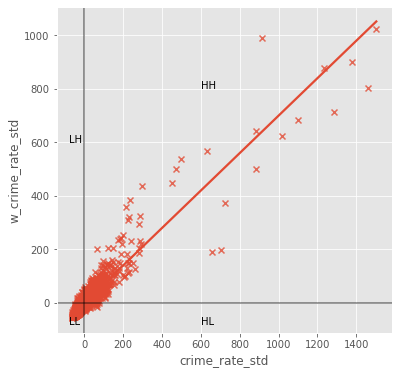

In [105]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(x="crime_rate_std", y="w_crime_rate_std", data=auto_cor, ci=None,marker='x')
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(600, 800, "HH", fontsize=10, c="black")
plt.text(600, -80, "HL", fontsize=10, c="black")
plt.text(-80, 600, "LH", fontsize=10, c="black")
plt.text(-80, -80, "LL", fontsize=10, c="black")
# Display
plt.show()

Most of the values are high-high clustering, some of them are low-low clustering. A much less small amount of values are low-high or high-low clustering. 

Next, show this on map.

In [106]:
from splot import esda as esdaplot
from pysal.explore import esda

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [107]:
lisa = esda.moran.Moran_Local(auto_cor["crime_rate"], w)

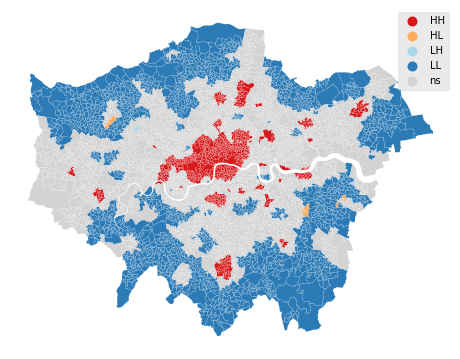

In [108]:
f, axs = plt.subplots(figsize=(8,8))
esdaplot.lisa_cluster(lisa, auto_cor, p=0.05, ax=axs)
ax.set_axis_off()
ax.set_title("Moran Cluster Map")
plt.show()

The map shows spatial autocorrelation, showing some high-high clusters in the inner city and low-low clusters along the boundary. The problem of autocorrelation in the ML model will be discussed later.

## Build machine learning models

How to understand the spatial autocorrelation problem?

The spatial auto correlation will very possibly lead to data leakage problem because random cross validation does not consider about the geometry info, which means some of the similar data will be randomly split into both train and validation dataset, causing data leakage problem.

How to deal with this problem?

The Kopczewska's paper (2022) made reviews about the spatial machine learning and comes up with 5 kinds of spatial ML model:

1. Classic ML + non-spatial variables + random cross-validation,

2. Classic ML + spatial all variables + random cross-validation,

3. Classic ML + spatial all variables + spatial cross-validation,

4. Classic ML + spatial selected variables + spatial cross-validation,

5. Spatial ML + spatial selected variables + spatial cross-validation.

This review mentioned that "approaches (1), (2) or (3) may not be fully reliable, due to the autocorrelation issues", and "the current standard of modelling is expressed by approach (4)". 

In this study, we will try to apply spatial cross validation. Thus, in the next part, by using two of the most classic ML: **Random Forest and XGBoost**, this study will apply random cross validation first and then use spatial cv to show whether there is improvement.

`Compare between:`
-   A: Classic ML + spatial selected variables + random cross-validation (Rcv)
-   B: Classic ML + spatial selected variables + spatial cross-validation (Scv)

### Split data

As mentioned above, We have already reduced dimension and automatically selected the most explained variables. After reducing dimension, only 6 main PCA features are left.

In [109]:
principalDf.head()

principal component 1  \
0                                  -2.1289   
1                                  -1.9070   
2                                  -1.7761   
3                                  -2.1336   
4                                   0.2085   

                     principal component 2  \
0                                  -0.8325   
1                                   0.0627   
2                                  -0.6734   
3                                   0.5973   
4                                   0.8460   

                     principal component 3  \
0                                   0.4498   
1                                   2.0045   
2                                  -0.3027   
3                                   1.8391   
4                                  -0.6552   

                     principal component 4  \
0                                  -0.0485   
1                                   0.9122   
2                                  -0.6081   
3                                   0.7444   
4                                  -0.1612   

                     principal component 5  \
0                                  -1.4666   
1                                  -1.1175   
2                                  -0.6833   
3                                  -0.6682   
4                                  -0.5882   

                     principal component 6  \
0                                   1.3608   
1                                   1.1262   
2                                   1.1140   
3                                  -1.5496   
4                                  -0.1256   

                                crime_rate  \
0                                   1.1170   
1                                   1.7320   
2                                   0.2718   
3                                   3.4960   
4                                  -0.4006   

                                  latitude  \
0                                   0.1326   
1                                   0.1598   
2                                   0.1378   
3                                   0.2691   
4                                   1.3212   

                                 longitude  
0                                   0.1627  
1                                   0.1663  
2                                   0.2120  
3                                   0.1083  
4                                   0.4814

At the very beginning of building machine learning models, split the data into train and test subsets.

------

- To prepare for the spatial cv, transform the latitude and longitude data into point geometry so that later we can use buffer to search and split spatial points.

In [110]:
point_all_x = gpd.GeoDataFrame(principalDf, geometry=gpd.points_from_xy(principalDf.longitude, principalDf.latitude))

------

In [111]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(point_all_x.drop(['crime_rate'], axis = 1), point_all_x.crime_rate, test_size=0.2,random_state=random_state_split)

In [112]:
print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(3868, 9) (3868,)
(967, 9) (967,)
True
True


In [113]:
train_x.columns

Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4',
       'principal component 5', 'principal component 6', 'latitude',
       'longitude', 'geometry'],
      dtype='object')

------

- Here, we prepare and store the geo value in "geo_train" for later use when **use spatial cv to split train data into train and validation data.**

In [114]:
geo_train = train_x['geometry']

------

In [115]:
train_x.columns

Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4',
       'principal component 5', 'principal component 6', 'latitude',
       'longitude', 'geometry'],
      dtype='object')

In [116]:
train_x = train_x[['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4',
       'principal component 5', 'principal component 6']]

In [117]:
test_x = test_x[['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4',
       'principal component 5', 'principal component 6']]

In [118]:
print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(3868, 6) (3868,)
(967, 6) (967,)
True
True


### Build and tune a Random Forest model.

Use random cross-validation to test and improve model estimation

In [119]:
%%time
regressor = RandomForestRegressor(random_state=10000)

# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30],
                   'min_samples_split':[2,4]}

search = GridSearchCV(regressor, hyperparameters,cv = 3).fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print (f"The best parameter value is: {search.best_params_}")
print (f"The best score is: {search.best_score_}")

The best parameter value is: {'max_depth': 20, 'min_samples_split': 4}
The best score is: 0.55770181126523
CPU times: user 20.2 s, sys: 55.6 ms, total: 20.2 s
Wall time: 20.3 s


In [120]:
rf_final = RandomForestRegressor(max_depth=search.best_params_['max_depth'], min_samples_split=search.best_params_['min_samples_split'], random_state=10000)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, min_samples_split=4, random_state=10000)

In [121]:
rf_result = {"data":["training data","testing data","difference"],
             "R2":[rf_final.score(X=train_x, y=train_y),(rf_final.score(X=test_x, y=test_y)),
                  rf_final.score(X=train_x, y=train_y)-(rf_final.score(X=test_x, y=test_y))],
            "RMSE":[mean_squared_error(train_y, rf_final.predict(train_x), squared=False),mean_squared_error(test_y, rf_final.predict(test_x), squared=False),
                   -(mean_squared_error(train_y, rf_final.predict(train_x), squared=False)-mean_squared_error(test_y, rf_final.predict(test_x), squared=False))],
            "Normalised RMSE":[mean_squared_error(train_y, rf_final.predict(train_x), squared=False)/np.mean(train_y),mean_squared_error(test_y, rf_final.predict(test_x), squared=False)/np.mean(test_y),
                              -(mean_squared_error(train_y, rf_final.predict(train_x), squared=False)/np.mean(train_y)-mean_squared_error(test_y, rf_final.predict(test_x), squared=False)/np.mean(test_y))]}

rf_result = pd.DataFrame(rf_result)
rf_result

data                                       R2  \
0  training data                                   0.9238   
1   testing data                                   0.5425   
2     difference                                   0.3813   

                                      RMSE  \
0                                   0.2759   
1                                   0.6781   
2                                   0.4022   

                           Normalised RMSE  
0                                 -33.2069  
1                                  20.4025  
2                                  53.6094

                                                    Importance
Feature                                                       
principal component 1                                   0.6543
principal component 4                                   0.1334
principal component 2                                   0.0910
principal component 5                                   0.0797
principal component 3                                   0.0557
principal component 6                                   0.0498


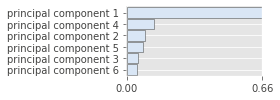

In [122]:
# the importances function returns a dataframe of two columns, Feature and Importance, and the features are ranked from the most important to the least.
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)

## Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imp)
viz.view()

### Build and tune a XGBoost regression model.

Parameters: 
- n_estimators  "Number of gradient boosted trees. Equivalent to number 
                of boosting rounds."
- learning_rate "Boosting learning rate (also known as “eta”)"
- max_depth     "Maximum depth of a tree. Increasing this value will make 
               the model more complex and more likely to overfit." 

In [123]:
%%time
regressor = XGBRegressor()

hyperparameters = {"max_depth":    [4, 5],
                  "n_estimators": [500, 600],
                  "learning_rate": [0.015]}
search = GridSearchCV(regressor, hyperparameters, cv=3).fit(train_x, train_y)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 600}
CPU times: user 1min 48s, sys: 3.16 s, total: 1min 51s
Wall time: 29.5 s


In [124]:
xgb_final = XGBRegressor(max_depth=search.best_params_['max_depth'], n_estimators=search.best_params_['n_estimators'],learning_rate = search.best_params_['learning_rate'])
xgb_final.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.015, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [125]:
xgb_result = {"data":["training data","testing data","difference"],
             "R2":[xgb_final.score(X=train_x, y=train_y),(xgb_final.score(X=test_x, y=test_y)),
                  xgb_final.score(X=train_x, y=train_y)-(xgb_final.score(X=test_x, y=test_y))],
            "RMSE":[mean_squared_error(train_y, xgb_final.predict(train_x), squared=False),mean_squared_error(test_y, xgb_final.predict(test_x), squared=False),
                   -(mean_squared_error(train_y, xgb_final.predict(train_x), squared=False)-mean_squared_error(test_y, xgb_final.predict(test_x), squared=False))],
            "Normalised RMSE":[mean_squared_error(train_y, xgb_final.predict(train_x), squared=False)/np.mean(train_y),mean_squared_error(test_y, xgb_final.predict(test_x), squared=False)/np.mean(test_y),
                              -(mean_squared_error(train_y, xgb_final.predict(train_x), squared=False)/np.mean(train_y)-mean_squared_error(test_y, xgb_final.predict(test_x), squared=False)/np.mean(test_y))]}

xgb_result = pd.DataFrame(xgb_result)
xgb_result

data                                       R2  \
0  training data                                   0.7145   
1   testing data                                   0.5479   
2     difference                                   0.1666   

                                      RMSE  \
0                                   0.5339   
1                                   0.6740   
2                                   0.1401   

                           Normalised RMSE  
0                                 -64.2568  
1                                  20.2811  
2                                  84.5379

                                                    Importance
Feature                                                       
principal component 1                                   0.6479
principal component 4                                   0.1422
principal component 6                                   0.0955
principal component 5                                   0.0793
principal component 2                                   0.0733
principal component 3                                   0.0620


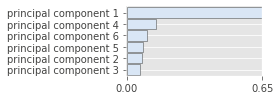

In [126]:
# the importances function returns a dataframe of two columns, Feature and Importance, and the features are ranked from the most important to the least.
imp = rfpimp.importances(xgb_final, test_x, test_y)
print(imp)

## Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imp)
viz.view()

### Spatial cross validation.

<div>
<img src="https://raw.githubusercontent.com/yuxinnie/DSSS/main/image/13_partitioning.png" width="500"/>
</div>

In [127]:
! pip install spacv

In [128]:
import spacv

#### Random Forest with Spatial cv

In [129]:
%%time
regressor = RandomForestRegressor(random_state=10000)

hyperparameters = {'max_depth':[10,20,30],
                   'min_samples_split':[2,4]}

skcv = spacv.SKCV(n_splits=3, buffer_radius=.1).split(geo_train)

search = GridSearchCV(regressor, 
                   hyperparameters, 
                   cv = skcv # An iterable yielding (train, test) splits as arrays of indices
                  ).fit(train_x,train_y)

# we can query the best parameter value and its accuracy score
print (f"The best parameter value is: {search.best_params_}")
print (f"The best score is: {search.best_score_}")

The best parameter value is: {'max_depth': 10, 'min_samples_split': 4}
The best score is: 0.3958180237637337
CPU times: user 19.5 s, sys: 328 ms, total: 19.9 s
Wall time: 19.3 s


In [130]:
rf_final_scv = RandomForestRegressor(max_depth=search.best_params_['max_depth'], min_samples_split=search.best_params_['min_samples_split'], random_state=10000)
rf_final_scv.fit(train_x, train_y)

RandomForestRegressor(max_depth=10, min_samples_split=4, random_state=10000)

In [131]:
rfscv_result = {"data":["training data","testing data","difference"],
             "R2":[rf_final_scv.score(X=train_x, y=train_y),(rf_final_scv.score(X=test_x, y=test_y)),
                  rf_final_scv.score(X=train_x, y=train_y)-(rf_final_scv.score(X=test_x, y=test_y))],
            "RMSE":[mean_squared_error(train_y, rf_final_scv.predict(train_x), squared=False),mean_squared_error(test_y, rf_final_scv.predict(test_x), squared=False),
                   -(mean_squared_error(train_y, rf_final_scv.predict(train_x), squared=False)-mean_squared_error(test_y, rf_final_scv.predict(test_x), squared=False))],
            "Normalised RMSE":[mean_squared_error(train_y, rf_final_scv.predict(train_x), squared=False)/np.mean(train_y),mean_squared_error(test_y, rf_final_scv.predict(test_x), squared=False)/np.mean(test_y),
                              -(mean_squared_error(train_y, rf_final_scv.predict(train_x), squared=False)/np.mean(train_y)-mean_squared_error(test_y, rf_final_scv.predict(test_x), squared=False)/np.mean(test_y))]}

rfscv_result = pd.DataFrame(rfscv_result)
rfscv_result

data                                       R2  \
0  training data                                   0.8098   
1   testing data                                   0.5476   
2     difference                                   0.2622   

                                      RMSE  \
0                                   0.4358   
1                                   0.6743   
2                                   0.2385   

                           Normalised RMSE  
0                                 -52.4521  
1                                  20.2884  
2                                  72.7406

#### XGBoost with Spatial cv

In [132]:
%%time
regressor = XGBRegressor()
hyperparameters = {"max_depth":    [4, 5],
                  "n_estimators": [500, 600],
                  "learning_rate": [0.015]}
skcv = spacv.SKCV(n_splits=3, buffer_radius=.2).split(geo_train)

search = GridSearchCV(regressor, 
                   hyperparameters, 
                   cv = skcv # An iterable yielding (train, test) splits as arrays of indices
                  ).fit(train_x,train_y)

# we can query the best parameter value and its accuracy score
print (f"The best parameter value is: {search.best_params_}")
print (f"The best score is: {search.best_score_}")

The best parameter value is: {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 500}
The best score is: 0.44657184121128474
CPU times: user 1min 59s, sys: 4.35 s, total: 2min 4s
Wall time: 33.6 s


In [133]:
xgb_final_scv = XGBRegressor(max_depth=search.best_params_['max_depth'], n_estimators=search.best_params_['n_estimators'],learning_rate = search.best_params_['learning_rate'])
xgb_final_scv.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.015, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [134]:
xgbscv_result = {"data":["training data","testing data","difference"],
             "R2":[xgb_final_scv.score(X=train_x, y=train_y),(xgb_final_scv.score(X=test_x, y=test_y)),
                  xgb_final_scv.score(X=train_x, y=train_y)-(xgb_final_scv.score(X=test_x, y=test_y))],
            "RMSE":[mean_squared_error(train_y, xgb_final_scv.predict(train_x), squared=False),mean_squared_error(test_y, xgb_final_scv.predict(test_x), squared=False),
                   -(mean_squared_error(train_y, xgb_final_scv.predict(train_x), squared=False)-mean_squared_error(test_y, xgb_final_scv.predict(test_x), squared=False))],
            "Normalised RMSE":[mean_squared_error(train_y, xgb_final_scv.predict(train_x), squared=False)/np.mean(train_y),mean_squared_error(test_y, xgb_final_scv.predict(test_x), squared=False)/np.mean(test_y),
                              -(mean_squared_error(train_y, xgb_final_scv.predict(train_x), squared=False)/np.mean(train_y)-mean_squared_error(test_y, xgb_final_scv.predict(test_x), squared=False)/np.mean(test_y))]}

xgbscv_result = pd.DataFrame(xgbscv_result)
xgbscv_result

data                                       R2  \
0  training data                                   0.7043   
1   testing data                                   0.5476   
2     difference                                   0.1567   

                                      RMSE  \
0                                   0.5434   
1                                   0.6742   
2                                   0.1309   

                           Normalised RMSE  
0                                 -65.3955  
1                                  20.2870  
2                                  85.6825

## Result and discussion

Add all these outcomes of different models together and make a comparison.

In [135]:
result = pd.DataFrame(columns=['model','training_data','testing_data','difference'])

In [136]:
RF = {'model':'Random_Forest','training_data':rf_result["R2"][0], 'testing_data':rf_result["R2"][1], 'difference':rf_result["R2"][2]}
XGB = {'model':'XGBoost','training_data':xgb_result["R2"][0], 'testing_data':xgb_result["R2"][1], 'difference':xgb_result["R2"][2]}
RF_scv = {'model':'Random_Forest_scv','training_data':rfscv_result["R2"][0], 'testing_data':rfscv_result["R2"][1], 'difference':rfscv_result["R2"][2]}
XGB_scv = {'model':'XGBoost_scv','training_data':xgbscv_result["R2"][0], 'testing_data':xgbscv_result["R2"][1], 'difference':xgbscv_result["R2"][2]}

In [137]:
rows = [RF,RF_scv,XGB,XGB_scv]

In [138]:
for new_row in rows:
    result = result.append(new_row, ignore_index=True)

In [139]:
result

model                            training_data  \
0      Random_Forest                                   0.9238   
1  Random_Forest_scv                                   0.8098   
2            XGBoost                                   0.7145   
3        XGBoost_scv                                   0.7043   

                              testing_data  \
0                                   0.5425   
1                                   0.5476   
2                                   0.5479   
3                                   0.5476   

                                difference  
0                                   0.3813  
1                                   0.2622  
2                                   0.1666  
3                                   0.1567

<AxesSubplot:>

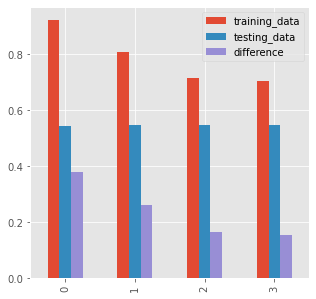

In [143]:
result.plot(kind="bar",figsize=(5,5))

Here we have gathered results of the four models. First, compare between two kinds of models: random forest and xgboost. As shown in this barplot, random forest models have better fit on training data, both R2 are above 0.8, while the xgboost models performed worse on the training dataset, both only achieved around 0.73 R2. This is likely because of the algorithm of xgboost which on purpose add some "noise" to avoid overfit during the training process. It is beneficial for xgboost model to have better performance on the testing data and smaller difference on training and testing data. 

Then compare the random and spatial cross validation model. For random foreset models, the perfomance of spatial cv model on the testing was slightly higher than the non-spatial one. This is not a strong proof to say that spatial cv improved the model. For xgboost models, the spatial cv improved its performance on the training data, from 0.71 to 0.75. But the performance on the testing data was reduced a little.

From the result, it is hard to tell any obvious improvement of spatial cv, especially on their performance of testing dataset. We can notice from the hyperparameters these models chose were totally different. This means, different cross validation has impact on the hyperparameters a lot. However, a reasonable explaination for this result is that the computation resources and time are not allowed for more tuning options. That's why there are only 2 to 3 parameters to choose in the above code. These computation are really time-consuming, especially when there are more folders/splits of training data. If the range of hyperparameter could be larger and also add the number of cross-validation folder, there is a great chance that the performance of models differ much more.

Another way to improve the prediction performance is to use the stacking regression. Just like what Xu, L., Li, Z.(2021) did in their reaserch to predict the housing price by applying geo info, the stacking regression model can learn from both of the built models (like random forest and xgboost above) and significantly improve its performance.

Compared to the OLS model, ML models performed worse, without reaching a R2 value of 0.6. It is likely that due to the dimension reduction, 20% of explained variance was lost. The further study could focus on that and make more comparison.

In [141]:
end_time = time.time()
run_time = end_time - start_time
print("Total run time: ", run_time, "seconds")

Total run time:  211.8796911239624 seconds


## Conclusion

This study shows that predicting the crime rate in London only by the built environment features is possible. Though the accuracy of the OLS model or the ML model was not satisfying enough, the result of this study is still valuable and reflectable. Also, this is a step for future studies, especially for the countries with less social-economic data. The built environment features are intuitively understood and observed for everyone living in a city. 

Prediction of crime is such a complicated work due to its temporal and spatial dimensions. In this coursework, I choose to sum up and calculate the mean value of crime as the measurement of crime incident. However, it is noticeable that crime rate changed thorough last years, with a fluctuating trend all the time, especially during Covid period when the crime rate reduced significantly. 

Although this coursework use PCA to reduce dimension and save computation time and space, this could lead to a loss of feature. Considering the total explained variance are only 80.51%, the influence of feature loss could be under-rated.

In machine learning workflow, it is better to build a pipeline for it. This could help the codes and the reaserch more organised and avoid data leakage risk. This is another direction for this study to further improve.

## Reference

(only list some of the papers here, other link references are in-text quote already)

Brantingham, P.L. and Brantingham, P.J. (1993) ‘Nodes, paths and edges: Considerations on the complexity of crime and the physical environment’, Journal of Environmental Psychology, 13(1), pp. 3–28. Available at: https://doi.org/10.1016/S0272-4944(05)80212-9.

Brown, B.B. and Altman, I. (1983) ‘Territoriality, defensible space and residential burglary: An environmental analysis’, Journal of Environmental Psychology, 3(3), pp. 203–220. Available at: https://doi.org/10.1016/S0272-4944(83)80001-2.

Guedes, I., Moreira, S. and Cardoso, C.S. (2021) ‘The Urban Security Image Database (USID): development and validation of an image dataset for experimental studies on fear of crime’, Journal of Experimental Criminology [Preprint]. Available at: https://doi.org/10.1007/s11292-021-09490-x.

Kopczewska, K. Spatial machine learning: new opportunities for regional science. Ann Reg Sci 68, 713–755 (2022). https://doi.org/10.1007/s00168-021-01101-x

Kuo, F.E. and Sullivan, W.C. (2001) ‘Environment and Crime in the Inner City: Does Vegetation Reduce Crime?’, Environment and Behavior, 33(3), pp. 343–367. Available at: https://doi.org/10.1177/0013916501333002.

Lynch, Kevin (1960). The Image of the City. The MIT Press. ISBN 0-262-62001-4.

Mak, B.K.L. and Jim, C.Y. (2022) ‘Contributions of human and environmental factors to concerns of personal safety and crime in urban parks’, Security Journal, 35(1), pp. 263–293. Available at: https://doi.org/10.1057/s41284-020-00277-9.

Tobler W., (1970) "A computer movie simulating urban growth in the Detroit region". Economic Geography, 46(Supplement): 234–240.

Xu, L. and Li, Z. (2021) ‘A New Appraisal Model of Second-Hand Housing Prices in China’s First-Tier Cities Based on Machine Learning Algorithms’, Computational Economics, 57(2), pp. 617–637. Available at: https://doi.org/10.1007/s10614-020-09973-5.